In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
np.bool = bool
import seaborn as sns
import run_classical
import ptitprince as pt#seaborn 0.11.0
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from sklearn.tree import export_graphviz
from subprocess import call
from sklearn.ensemble import RandomForestClassifier
import utils
from sklearn.decomposition import PCA
from utils import contaminated_hds
from sklearn.preprocessing import StandardScaler
import numpy as np
import run_classical
from scipy.stats import chi2
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from statsmodels.multivariate.manova import MANOVA
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy import stats
import itertools

In [16]:
RESULT_PATH = "final_evaluation/hypermutation/"
CONDITIONS = ["cll_dlbcl_hd", "nlphl_dlbcl_hd", "nlphl_dlbcl_hd_cll"]
SAVE_PLOTS = False
CONDITIONS_DICT = {'cll_dlbcl_hd': 'CLL_DLBCL_HD',
                  'nlphl_dlbcl_hd': 'NLPHL_DLBCL_HD',
                  'nlphl_dlbcl_hd_cll': 'NLPHL_DLBCL_HD_CLL'
                  }

In [17]:
MODELS = ["RandomForest", "LogisticRegression"]

# Load Model Results

In [19]:
df_conditions = pd.DataFrame()
results_conditions_df = pd.DataFrame()
settings_conditions_df = pd.DataFrame()

for condition in CONDITIONS:
    df, results_df, settings_df = utils.load_model_results(RESULT_PATH, condition, MODELS, "F1", weighted_metric=True)
    df["condition"] = condition
    results_df["condition"] = condition
    settings_df["condition"] = condition
    
    df_conditions = pd.concat([df_conditions, df],ignore_index = True)
    results_conditions_df = pd.concat([results_conditions_df, results_df], ignore_index = True)
    settings_conditions_df = pd.concat([settings_conditions_df, settings_df],  ignore_index = True)

## Select best model per n-clones based on validation F1 score for all conditions

In [21]:
best_models_per_clones = []

for condition in CONDITIONS:
    df = df_conditions[df_conditions.condition == condition]
    for i, group in df.groupby("n_clones"):
        group_reg = group[group.model == "LogisticRegression"]
        group_for = group[group.model == "RandomForest"]

        if len(group_reg) != 0:
            best_model_index = np.argmax(group_reg.mean_validation_F1)
            best_models_per_clones.append(group_reg.iloc[best_model_index:best_model_index+1].index[0])
        if len(group_for) != 0:
            best_model_index = np.argmax(group_for.mean_validation_F1)
            best_models_per_clones.append(group_for.iloc[best_model_index:best_model_index+1].index[0])

In [22]:
df_best = df_conditions.loc[best_models_per_clones]
df_best.sort_values(by=["model","condition"], inplace=True, ascending=False)

In [87]:
df_best

n_splits n_clones genefamily standardize ordinal_encoding onehot_encoding  \
438        3        1      False        True            False            True   
444        3        2      False       False            False            True   
464        3        3      False       False            False            True   
459        3        4      False        True            False            True   
465        3        5      False       False            False            True   
482        3       10      False        True            False            True   
437        3       20      False       False            False            True   
432        3       50      False        True            False            True   
503        3      100      False       False            False            True   
230        3        1      False       False            False            True   
249        3        2      False       False            False            True   
252        3        3      False        True            False            True   
231        3        4      False        True            False            True   
237        3        5      False        True            False            True   
217        3       10      False       False            False            True   
235        3       20      False       False            False            True   
240        3       50      False       False            False            True   
220        3      100      False       False            False            True   
31         3        1      False       False            False            True   
25         3        2      False       False            False            True   
10         3        3      False       False            False            True   
36         3        4      False        True            False            True   
9          3        5      False        True            False            True   
32         3       10      False        True            False            True   
19         3       20      False        True            False            True   
21         3       50      False        True            False            True   
22         3      100      False       False            False            True   
558        3        1      False        True            False            True   
628        3        2      False       False            False            True   
570        3        3      False       False            False            True   
541        3        4      False       False            False            True   
630        3        5      False        True            False            True   
546        3       10      False        True            False            True   
581        3       20      False        True            False            True   
597        3       50      False        True            False            True   
522        3      100      False        True            False            True   
306        3        1      False        True            False            True   
313        3        2      False        True            False            True   
351        3        3      False        True            False            True   
300        3        4      False        True            False            True   
296        3        5      False        True            False            True   
330        3       10      False        True            False            True   
345        3       20      False        True            False            True   
319        3       50      False        True            False            True   
380        3      100      False        True            False            True   
207        3        1      False        True            False            True   
157        3        2      False       False            False            True   
168        3        3      False       False            False            True   
146        3        4      False   

## Select overall best model per condition

In [23]:
best_models_test_per_condition = {}
best_models_valid_per_condition = {}
best_test_reg_per_condition = {}
best_test_for_per_condition = {}
best_valid_reg_per_condition = {}
best_valid_for_per_condition = {}
for i, condition in enumerate(CONDITIONS):
    df = df_best[df_best.condition == condition]
    if len(df) == 0:
        continue
    best_models_test_per_condition[condition] = list(df.iloc[np.argmax(df.test_F1)][["model", "run", "n_clones"]])
    best_models_valid_per_condition[condition] = list(df.iloc[np.argmax(df.mean_validation_F1)][["model", "run", "n_clones"]])
    
    df_reg = df[df.model == "LogisticRegression"]
    df_for = df[df.model == "RandomForest"]
    
    best_test_reg_per_condition[condition] = list(df_reg.iloc[np.argmax(df_reg.test_F1)][["model", "run", "n_clones"]])
    best_test_for_per_condition[condition] = list(df_for.iloc[np.argmax(df_for.test_F1)][["model", "run", "n_clones"]])
    best_valid_reg_per_condition[condition] = list(df_reg.iloc[np.argmax(df_reg.mean_validation_F1)][["model", "run", "n_clones"]])
    best_valid_for_per_condition[condition] = list(df_for.iloc[np.argmax(df_for.mean_validation_F1)][["model", "run", "n_clones"]])

# Validation Results

In [57]:
SAVE_PLOTS = True

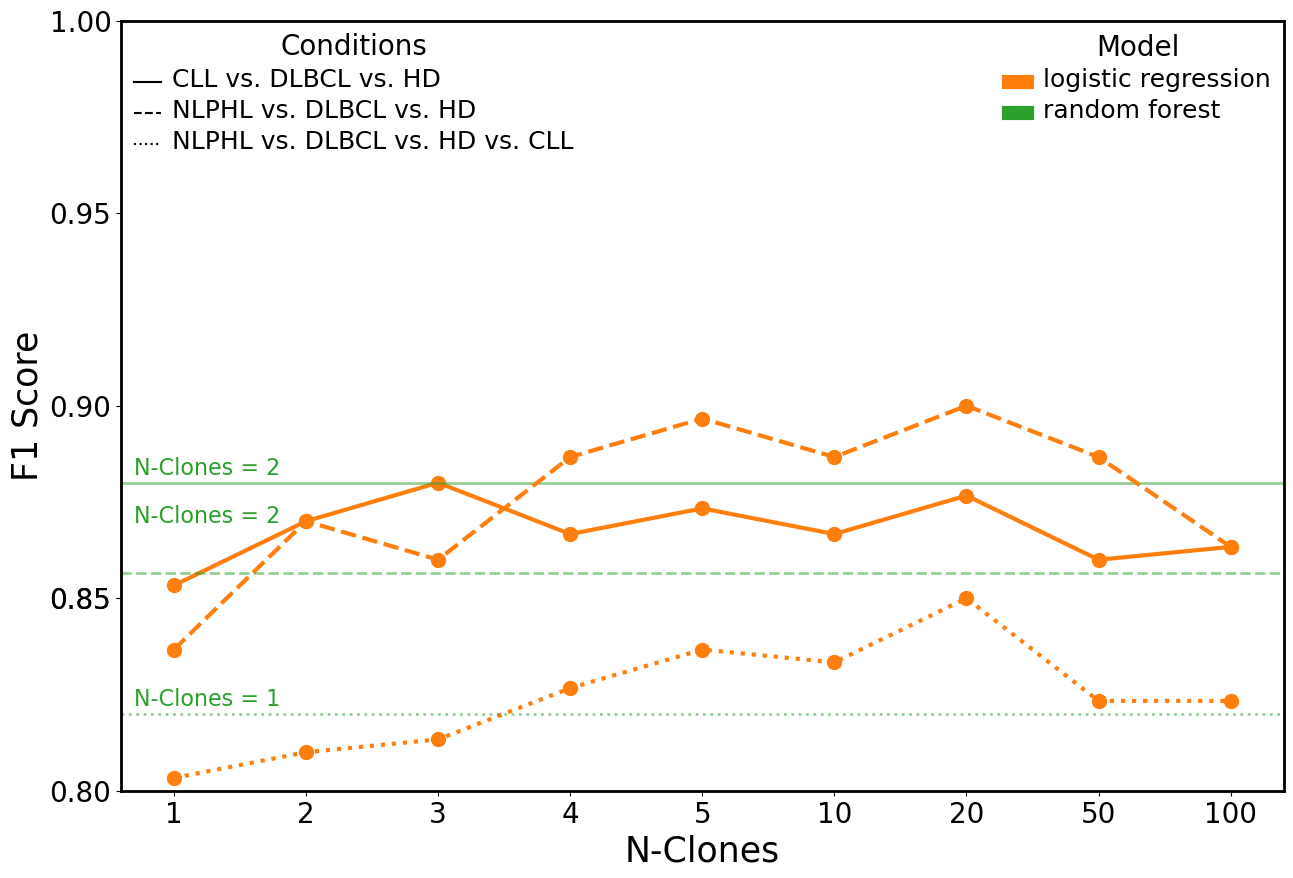

In [58]:
#markers = ["o", "s", "^"]
markers = ["o", "o", "o"]
lines = ["solid", "dashed", "dotted"]
#lines = ["solid", "solid", "solid"]

fig, ax = plt.subplots(figsize = (15,10))
for i, condition in enumerate(CONDITIONS):
    df = df_best[df_best.condition == condition]
    if len(df) == 0:
        continue
    df_reg = df[(df.model == "LogisticRegression")& (df.n_clones < 1000)]
    df_for = df[(df.model == "RandomForest")& (df.n_clones < 1000)]
    
    df_reg.sort_values(by="n_clones", inplace=True)
    df_for.sort_values(by="n_clones", inplace=True)
    
    x_values = np.unique(df_reg.n_clones)
    ax.plot(range(len(x_values)), df_reg.mean_validation_F1, color = "C1", marker = markers[i], linestyle=lines[i],linewidth=3)
    ax.scatter(range(len(x_values)), df_reg.mean_validation_F1, color = "C1", marker = markers[i], s=100)
    
    plt.axhline(y=np.amax(df_for.mean_validation_F1), color='C2', linestyle=lines[i], linewidth=2, alpha = 0.5, label='Best RandomForest Model')
    if i ==1:
        plt.annotate('N-Clones = %d' % (np.argmax(df_for.mean_validation_F1)+1), xy=(-0.3, np.amax(df_for.mean_validation_F1) + 0.013), color='C2', fontsize=16)
    else:
        plt.annotate('N-Clones = %d' % (np.argmax(df_for.mean_validation_F1)+1), xy=(-0.3, np.amax(df_for.mean_validation_F1) + 0.002), color='C2', fontsize=16)

    ax.tick_params(axis='both', labelsize=20)
ax.set_ylim(0.6,1)
ax.set_ylabel("F1 Score",fontsize=25)
ax.set_xlabel("N-Clones", fontsize=25)
ax.set_xticklabels([0] + list(x_values))

handles = [mpatches.Patch(color="C1", label="logistic regression", lw = 3),
          mpatches.Patch(color="C2", label="random forest", lw = 3)] 


ax.legend(handles=handles, ncols=1, title = "Model", loc="upper right", frameon=False)
legend = ax.get_legend()
legend.get_title().set_fontsize(20)  
for label in legend.get_texts():
    label.set_fontsize(18)

ax2 = ax.twinx()
condition_handles = []
for i, condition in enumerate(CONDITIONS):
    condition_handles.append(mlines.Line2D([], [], color="black", linestyle=lines[i], marker=None, markersize=20, label=CONDITIONS_DICT[condition].replace("_", " vs. ")))

ax2.legend(handles=condition_handles, ncols=1, title = "Conditions", frameon=False, loc = "upper left")
ax2.set_yticks([])
legend = ax2.get_legend()
ax.spines[['right', 'bottom','left', 'top']].set_linewidth(2)
legend.get_title().set_fontsize(20)  
for label in legend.get_texts():
    label.set_fontsize(18)
legend_position = legend.get_bbox_to_anchor().get_points()
ax.set_ylim((0.8,1))
ax.set_yticks([0.80, 0.85, 0.85, 0.90, 0.95, 1.00])

if SAVE_PLOTS:
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig('best_model_validation_results.svg')

# Test Results

In [59]:
SAVE_PLOTS = True

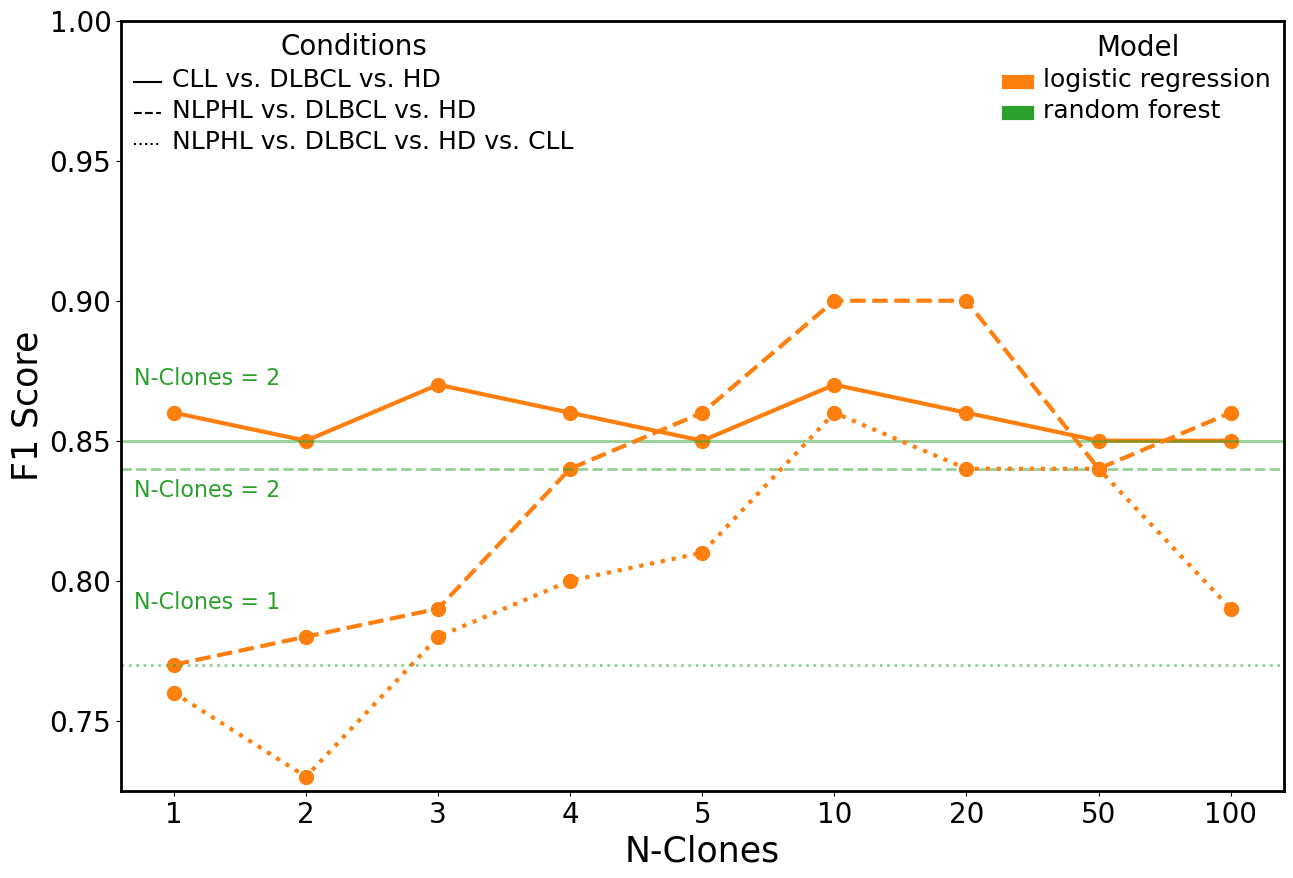

In [61]:
markers = ["o", "o", "o"]
lines = ["solid", "dashed", "dotted"]

fig, ax = plt.subplots(figsize = (15,10))
for i, condition in enumerate(CONDITIONS):
    df = df_best[df_best.condition == condition]
    if len(df) == 0:
        continue
    df_reg = df[(df.model == "LogisticRegression") & (df.n_clones < 1000)]
    df_for = df[(df.model == "RandomForest") & (df.n_clones < 1000)]
    
    df_reg.sort_values(by="n_clones", inplace=True)
    df_for.sort_values(by="n_clones", inplace=True)
    
    x_values = np.unique(df_reg.n_clones)
    ax.plot(range(len(x_values)), df_reg.test_F1, color = "C1", marker = markers[i], linestyle=lines[i],linewidth=3)
    ax.scatter(range(len(x_values)), df_reg.test_F1, color = "C1", marker = markers[i], s=100)
    
    for_nclones = best_valid_for_per_condition[condition][2]
    f1 = df_for[df_for.n_clones == for_nclones].test_F1.iloc[0]
    plt.axhline(y=f1, color='C2', linestyle=lines[i], linewidth=2, alpha = 0.5, label='Random Forest Model')
    if i == 1:
        plt.annotate('N-Clones = %d' % for_nclones, xy=(-0.3, f1 - 0.01), color='C2', fontsize=16)
    else:
        plt.annotate('N-Clones = %d' % for_nclones, xy=(-0.3, f1 + 0.02), color='C2', fontsize=16)
    
    
    ax.tick_params(axis='both', labelsize=20)
ax.set_ylim(0.6,1)
ax.set_ylabel("F1 Score",fontsize=25)
ax.set_xlabel("N-Clones", fontsize=25)
ax.set_xticklabels([0] + list(x_values))

handles = [mpatches.Patch(color="C1", label="logistic regression", lw = 3),
          mpatches.Patch(color="C2", label="random forest", lw = 3)] 


ax.legend(handles=handles, ncols=1, title = "Model", loc="upper right", frameon=False)
legend = ax.get_legend()
legend.get_title().set_fontsize(20)  
for label in legend.get_texts():
    label.set_fontsize(18)

ax2 = ax.twinx()
condition_handles = []
for i, condition in enumerate(CONDITIONS):
    condition_handles.append(mlines.Line2D([], [], color="black", linestyle=lines[i], marker=None, markersize=20, label=CONDITIONS_DICT[condition].replace("_", " vs. ")))

ax2.legend(handles=condition_handles, ncols=1, title = "Conditions", frameon=False, loc = "upper left")
ax2.set_yticks([])
legend = ax2.get_legend()
legend.get_title().set_fontsize(20)  
for label in legend.get_texts():
    label.set_fontsize(18)
legend_position = legend.get_bbox_to_anchor().get_points()
ax.spines[['right', 'bottom','left', 'top']].set_linewidth(2)
ax.set_ylim((0.725,1))

if SAVE_PLOTS:
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig('best_model_test_results.svg')

In [63]:
SAVE_PLOTS = True

# Feature Importance Random Forest

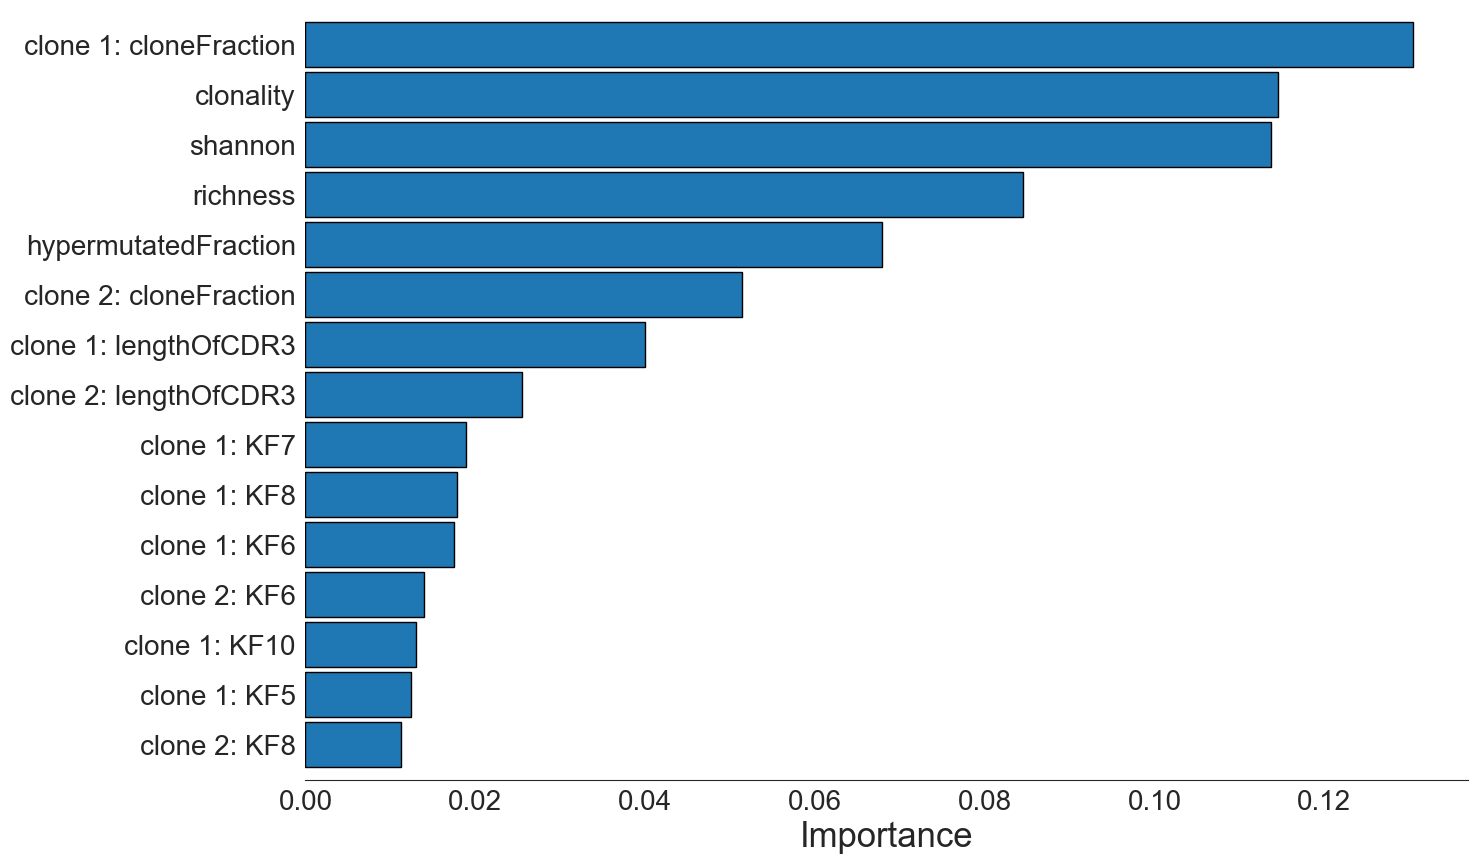

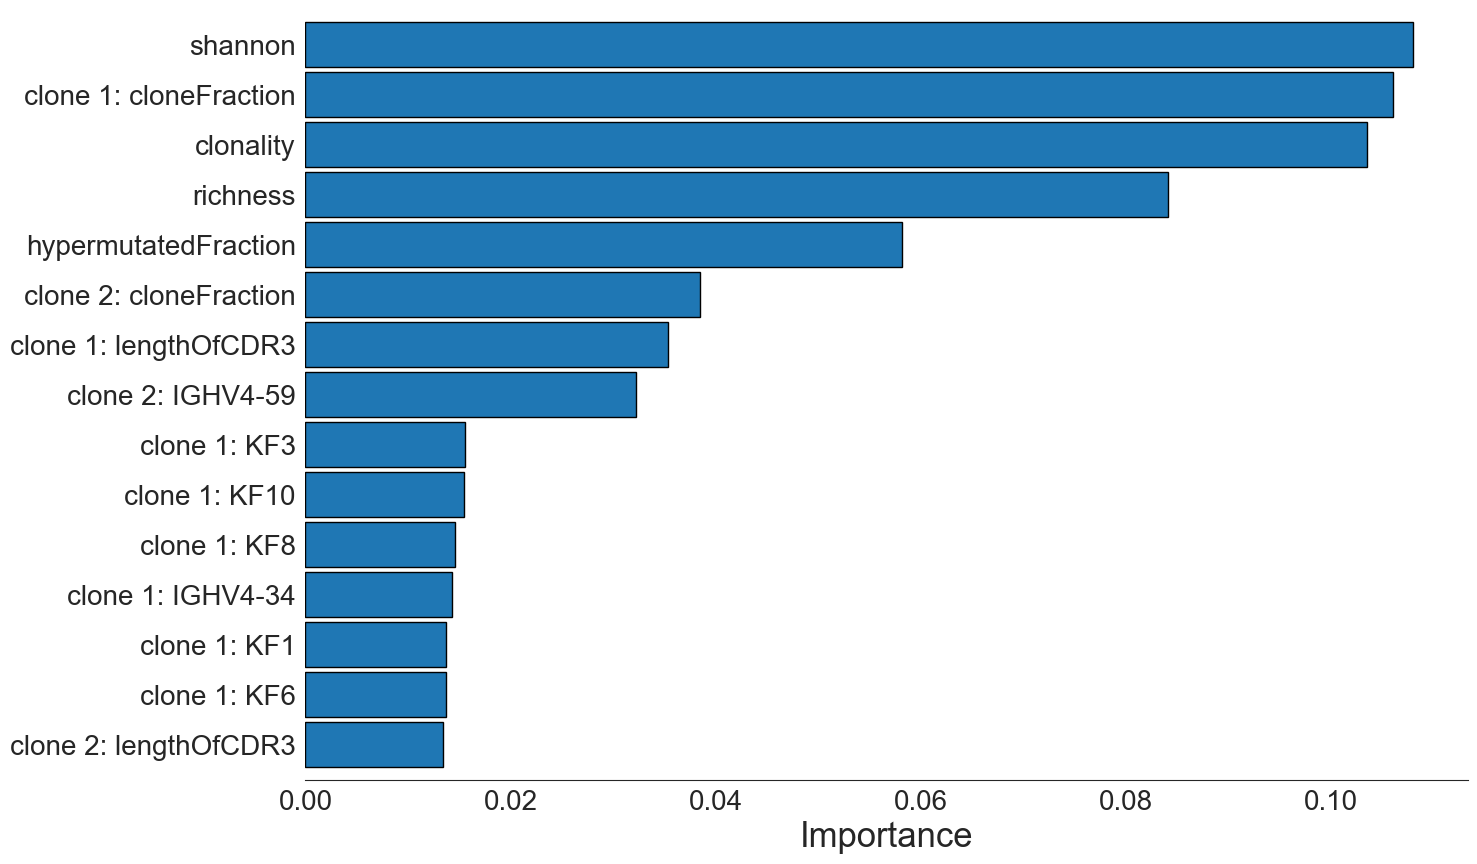

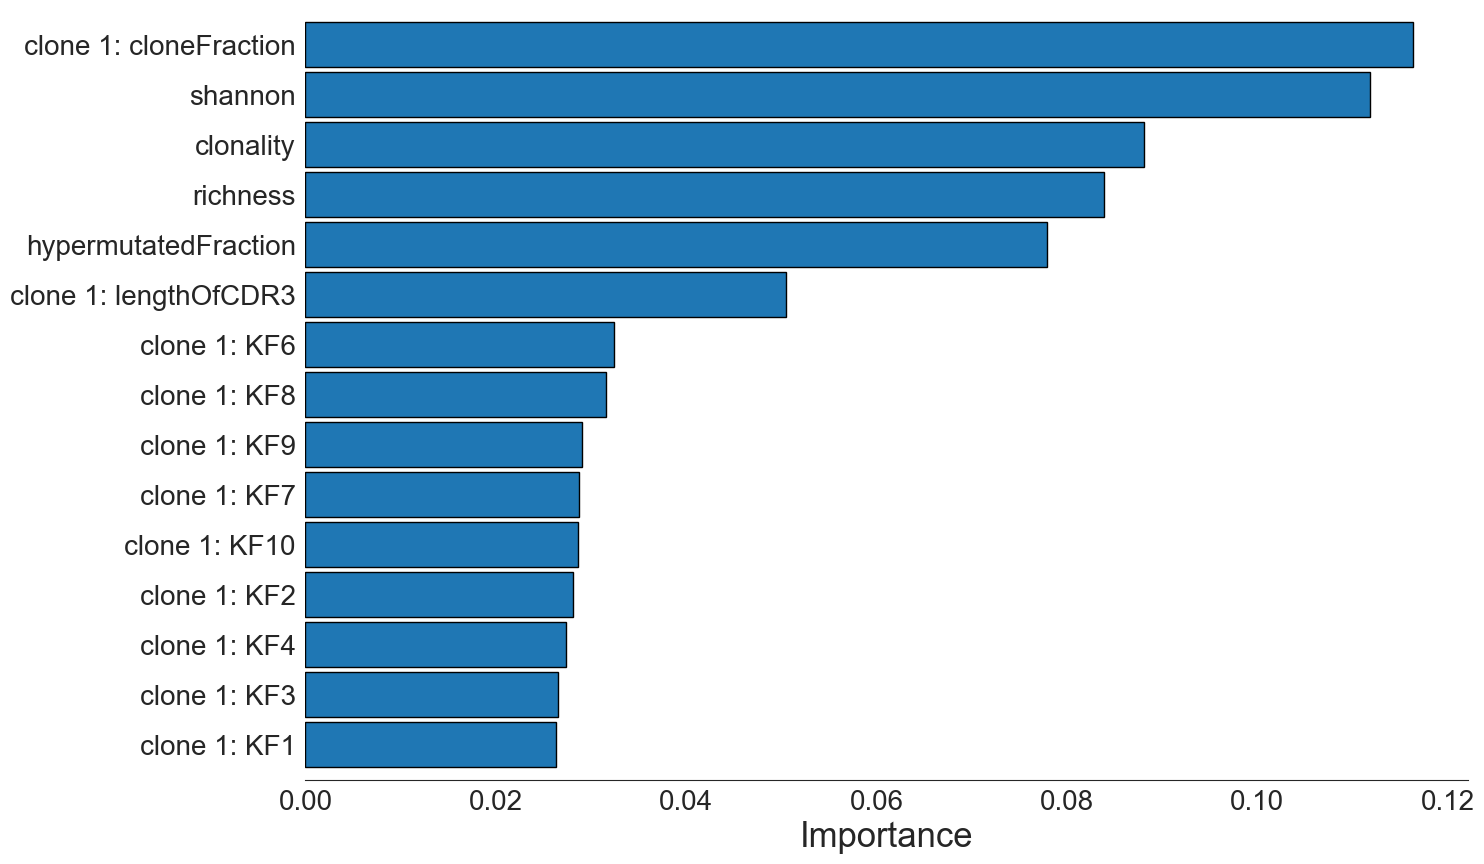

In [64]:
sns.set_style(style="white")

top_15_features = []

best_feature_importance_df = pd.DataFrame()
for condition in best_valid_for_per_condition:
    model = best_valid_for_per_condition[condition][0]
    run = best_valid_for_per_condition[condition][1]
    if model == "RandomForest":
        path = os.path.join(RESULT_PATH,condition,"outputs_" +model, run, "feature_importances.json")
        
        with open(path) as f:
            settings = f.read()
            settings = settings.replace("\n", "").strip()
            settings = json.loads(settings)
        

        fig, ax = plt.subplots(figsize=(15,10))
        ax.yaxis.grid(visible=False)
        ax.xaxis.grid(visible=False)
        feature_importance = pd.DataFrame({'Feature': list(settings.keys()), 'Importance': np.abs(list(settings.values()))})
        feature_importance = feature_importance.sort_values('Importance', ascending=True)
        feature_importance.iloc[-15:].plot(x='Feature', y='Importance', kind='barh', ax=ax , edgecolor = "black", width=0.9)   
        ax.get_legend().remove()
        top_15_features.append(list(feature_importance.iloc[-15:].Feature))
    
        new_ticks = []
        for tick in ax.get_yticklabels():
            tick_text = tick.get_text()
            if "_" in tick_text:
                splitted = tick_text.split("_")
                clone = int(splitted[1]) + 1
                splitted = np.delete(splitted, 1)
                new_tick = "clone %s: " % clone + splitted[-1]
                new_ticks.append(new_tick)
            else:
                new_ticks.append(tick_text)
        ax.set_yticklabels(list(new_ticks))
        ax.tick_params(axis='both', labelsize=20)
        ax.set_ylabel("",fontsize=18)
        if model == "RandomForest":
            ax.set_xlabel("Importance", fontsize=25)
        else:
            ax.set_xlabel("Magnitude of coefficients", fontsize=25)

        ax.spines[['right', 'top','left']].set_visible(False)
       

        feature_importance["condition"] = condition
        best_feature_importance_df = pd.concat([best_feature_importance_df, feature_importance])
        
        if SAVE_PLOTS:
            plt.rcParams['svg.fonttype'] = 'none'
            plt.savefig('feature_importance_random_forest_%s.svg' % condition)

## Random Forest Decision Trees

In [65]:
cond_lymphom_dict = {'cll_dlbcl_hd': ["cll", "dlbcl", "gcb_dlbcl", "abc_dlbcl", "hd"],
                    'nlphl_dlbcl_hd': ["nlphl", "dlbcl", "gcb_dlbcl", "abc_dlbcl", "hd"],
                    'nlphl_dlbcl_hd_cll': ["nlphl", "dlbcl", "gcb_dlbcl", "abc_dlbcl", "hd", "cll"]}

In [66]:
cond_comparison_dict = {
    "cll_dlbcl_hd" : [['cll'], ["dlbcl", "gcb_dlbcl", "abc_dlbcl"], ['hd']],
    "nlphl_dlbcl_hd" : [['nlphl'], ["dlbcl", "gcb_dlbcl", "abc_dlbcl"], ['hd']],
    "nlphl_dlbcl_hd_cll" : [['nlphl'], ["dlbcl", "gcb_dlbcl", "abc_dlbcl"], ['hd'], ["cll"]]
}

In [67]:
cond_labels_dict = {
    "cll_dlbcl_hd" : ['CLL', 'DLBCL', 'HD'],
    "nlphl_dlbcl_hd" : ['NLPHL', 'DLBCL', 'HD'],
    "nlphl_dlbcl_hd_cll" : ['NLPHL', 'DLBCL', 'HD', 'CLL']
}

In [69]:
sampling_strategies = {
'None': None,
'adasyn': ADASYN(random_state=42),
'random_over': RandomOverSampler(random_state=42),
'smote': SMOTE(random_state=42),
'random_under' : RandomUnderSampler(random_state=42)
}
    

path_dir = "data/"
selected_features = ['cloneFraction', 'lengthOfCDR3']  + ['bestVGene', 'bestDGene', 'bestJGene'] + ['KF%i' %i for i in range(1, 11)]
selected_features += ["clonality"] 
selected_features += ["richness"]
selected_features += ["shannon"]
selected_features += ["hypermutatedFraction"]

feature_names = ['cloneFraction', 'lengthOfCDR3', 'clonality', 'shannon', 'richness', 'hypermutatedFraction']  + ['bestVGene', 'bestDGene', 'bestJGene'] + ['KF%i' %i for i in range(1, 11)] 
object_types = ['float64', 'int64', 'float64', 'float64', 'float64', 'float64']  +  ['object', 'object', 'object']+['float64' for i in range(10)] 

# create dict from feature name to object type
feature_dict = {}
for i in range(len(feature_names)):
    feature_dict[feature_names[i]] = object_types[i]

selected_object_types = [feature_dict[feature] for feature in selected_features]


for condition in ["cll_dlbcl_hd"]:      
    comparisons = cond_comparison_dict[condition]
    comparisons_labels = cond_labels_dict[condition]
        
    class_files, number_of_repertoires = run_classical.load_metadata(comparisons, "IGH", path_dir)
    
    model = best_valid_for_per_condition[condition][0]
    run = best_valid_for_per_condition[condition][1]
    path = os.path.join(RESULT_PATH,condition,"outputs_" +model, run, "settings.json")
    
    with open(path) as f:
        settings = f.read()
        settings = settings.replace("\n", "").strip()
        settings = json.loads(settings)

    X, y, clone_fractions = run_classical.create_features(class_files, 
                                            selected_features, 
                                            selected_object_types, 
                                            settings["n_clones"], 
                                            onehot_encoding=settings["onehot_encoding"], 
                                            ordinal_encoding=settings["ordinal_encoding"], 
                                            standardize=settings["standardize"], 
                                            genefamily=settings["genefamily"])

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    train_index, test_index =  sss.split(X, y).__next__()

    X_test = X.iloc[test_index]
    y_test = y[test_index]
    X = X.iloc[train_index]
    y = y[train_index]
    sampler = sampling_strategies[settings["sampler"]]
    if sampler is not None:
        X, y = sampler.fit_resample(X, y)

    model = RandomForestClassifier(n_estimators=settings["n_estimators"], max_depth = settings["max_depth"], random_state=42)
    model.fit(X.values, y)
    
    for i in range(5):
        estimator = model.estimators_[i]


        # Export as dot file
        export_graphviz(estimator, out_file='tree_%d.dot' % i, 
                        feature_names = X.columns,
                        class_names = ["cll", "dlbcl", "hd"],
                        rounded = True, proportion = False, 
                        precision = 2, filled = False)

Number of Class 1 repertoires: 348
Number of Class 2 repertoires: 182
Number of Class 3 repertoires: 291


# Feature Coefficients Logistic Regression

In [70]:
cond_lymphom_dict = {'cll_dlbcl_hd': ["cll", "dlbcl", "gcb_dlbcl", "abc_dlbcl", "hd"],
                    'nlphl_dlbcl_hd': ["nlphl", "dlbcl", "gcb_dlbcl", "abc_dlbcl", "hd"],
                    'nlphl_dlbcl_hd_cll': ["nlphl", "dlbcl", "gcb_dlbcl", "abc_dlbcl", "hd", "cll"]}

In [71]:
cond_comparison_dict = {
    "cll_dlbcl_hd" : [['cll'], ["dlbcl", "gcb_dlbcl", "abc_dlbcl"], ['hd']],
    "nlphl_dlbcl_hd" : [['nlphl'], ["dlbcl", "gcb_dlbcl", "abc_dlbcl"], ['hd']],
    "nlphl_dlbcl_hd_cll" : [['nlphl'], ["dlbcl", "gcb_dlbcl", "abc_dlbcl"], ['hd'], ["cll"]]
}

In [72]:
cond_labels_dict = {
    "cll_dlbcl_hd" : ['CLL', 'DLBCL', 'HD'],
    "nlphl_dlbcl_hd" : ['NLPHL', 'DLBCL', 'HD'],
    "nlphl_dlbcl_hd_cll" : ['NLPHL', 'DLBCL', 'HD', 'CLL']
}

In [77]:
coef_per_condition = {}
models_per_condition = {}

sampling_strategies = {
'None': None,
'adasyn': ADASYN(random_state=42),
'random_over': RandomOverSampler(random_state=42),
'smote': SMOTE(random_state=42),
'random_under' : RandomUnderSampler(random_state=42)
}
    


path_dir = "data/"
selected_features = ['cloneFraction', 'lengthOfCDR3']  + ['bestVGene', 'bestDGene', 'bestJGene'] + ['KF%i' %i for i in range(1, 11)]
selected_features += ["clonality"] 
selected_features += ["richness"]
selected_features += ["shannon"]
selected_features += ["hypermutatedFraction"]

feature_names = ['cloneFraction', 'lengthOfCDR3', 'clonality', 'shannon', 'richness', 'hypermutatedFraction']  + ['bestVGene', 'bestDGene', 'bestJGene'] + ['KF%i' %i for i in range(1, 11)] 
object_types = ['float64', 'int64', 'float64', 'float64', 'float64', 'float64']  +  ['object', 'object', 'object']+['float64' for i in range(10)] 

# create dict from feature name to object type
feature_dict = {}
for i in range(len(feature_names)):
    feature_dict[feature_names[i]] = object_types[i]

selected_object_types = [feature_dict[feature] for feature in selected_features]


for condition in CONDITIONS:      
    comparisons = cond_comparison_dict[condition]
    comparisons_labels = cond_labels_dict[condition]
        
    class_files, number_of_repertoires = run_classical.load_metadata(comparisons, "IGH", path_dir)
    
    model = best_valid_reg_per_condition[condition][0]
    run = best_valid_reg_per_condition[condition][1]
    path = os.path.join(RESULT_PATH,condition,"outputs_" +model, run, "settings.json")
    if model == "LogisticRegression":
        with open(path) as f:
            settings = f.read()
            settings = settings.replace("\n", "").strip()
            settings = json.loads(settings)

        X, y, clone_fractions = run_classical.create_features(class_files, 
                                                selected_features, 
                                                selected_object_types, 
                                                settings["n_clones"], 
                                                onehot_encoding=settings["onehot_encoding"], 
                                                ordinal_encoding=settings["ordinal_encoding"], 
                                                standardize=settings["standardize"], 
                                                genefamily=settings["genefamily"])

        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
        train_index, test_index =  sss.split(X, y).__next__()

        X_test = X.iloc[test_index]
        y_test = y[test_index]
        X = X.iloc[train_index]
        y = y[train_index]
        
        sampler = sampling_strategies[settings["sampler"]]
        if sampler is not None:
            X, y = sampler.fit_resample(X, y)

        model = LogisticRegression(max_iter=settings["max_iter"], penalty=settings['regularization'], C=settings['C'], solver=settings['solver'], l1_ratio=settings["l1_ratio"], n_jobs=8)
        model.fit(X.values, y)

        coefficients = model.coef_
        models_per_condition[condition] = model

        df_coef = pd.DataFrame({'Feature': [], 'Importance':[], 'Class' : []})
        for c in range(coefficients.shape[0]):
            if c == 0:
                df_coef = pd.DataFrame({'Feature': list(X.columns), 'Coefficient':coefficients[c], 'Class' : comparisons_labels[c]})

            else:
                df_i = pd.DataFrame({'Feature': list(X.columns), 'Coefficient':coefficients[c], 'Class' : comparisons_labels[c]})
                df_coef = pd.concat([df_coef, df_i])
        coef_per_condition[condition] = df_coef

Number of Class 1 repertoires: 348
Number of Class 2 repertoires: 182
Number of Class 3 repertoires: 291


/Users/labadmin/anaconda3/envs/bonn17/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of Class 1 repertoires: 90
Number of Class 2 repertoires: 182
Number of Class 3 repertoires: 291
Number of Class 1 repertoires: 90
Number of Class 2 repertoires: 182
Number of Class 3 repertoires: 291
Number of Class 4 repertoires: 348


In [78]:
SAVE_PLOTS=True

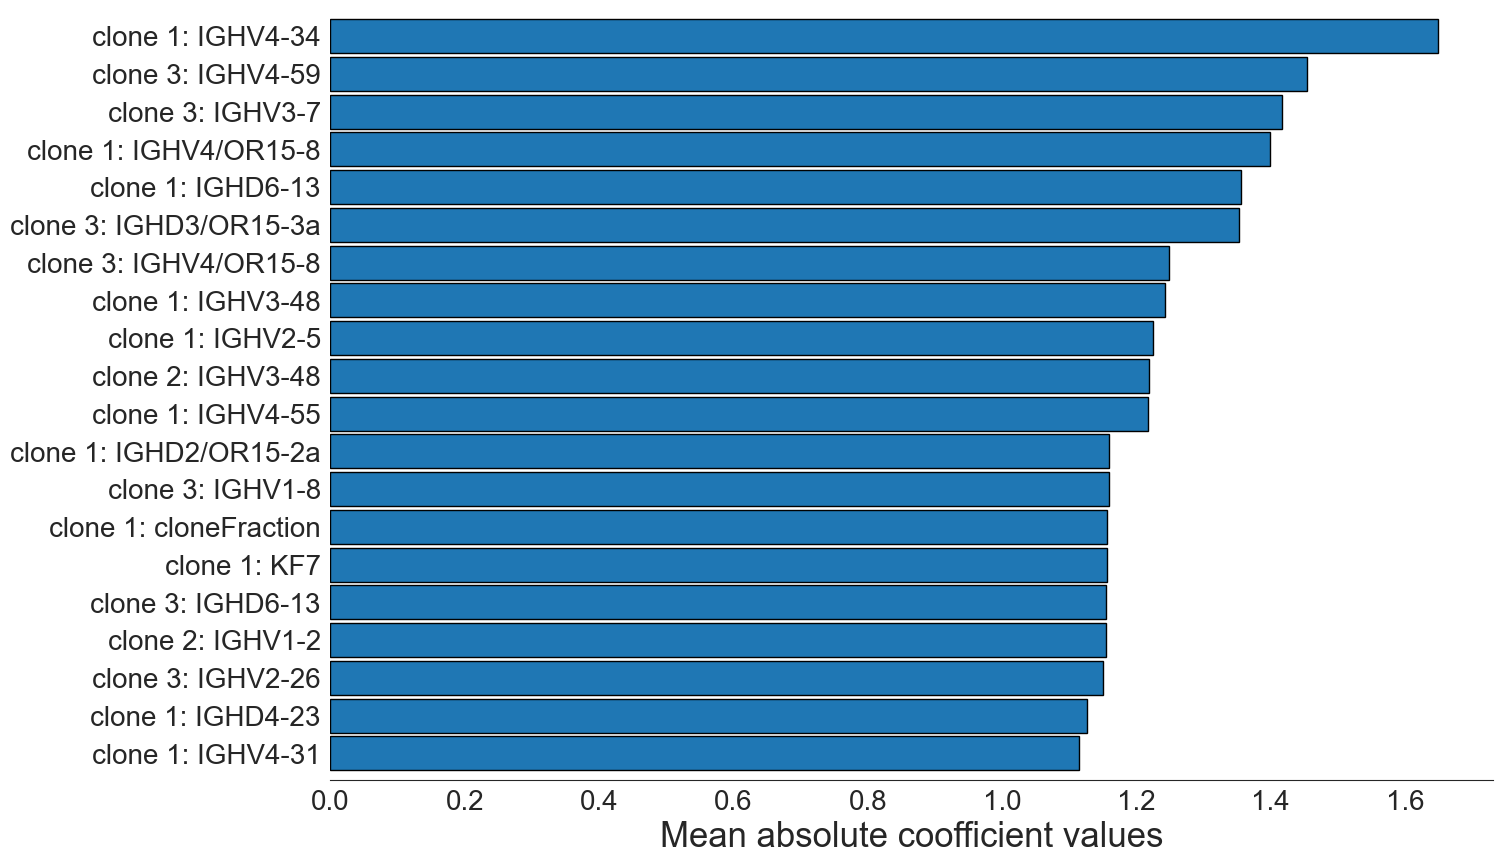

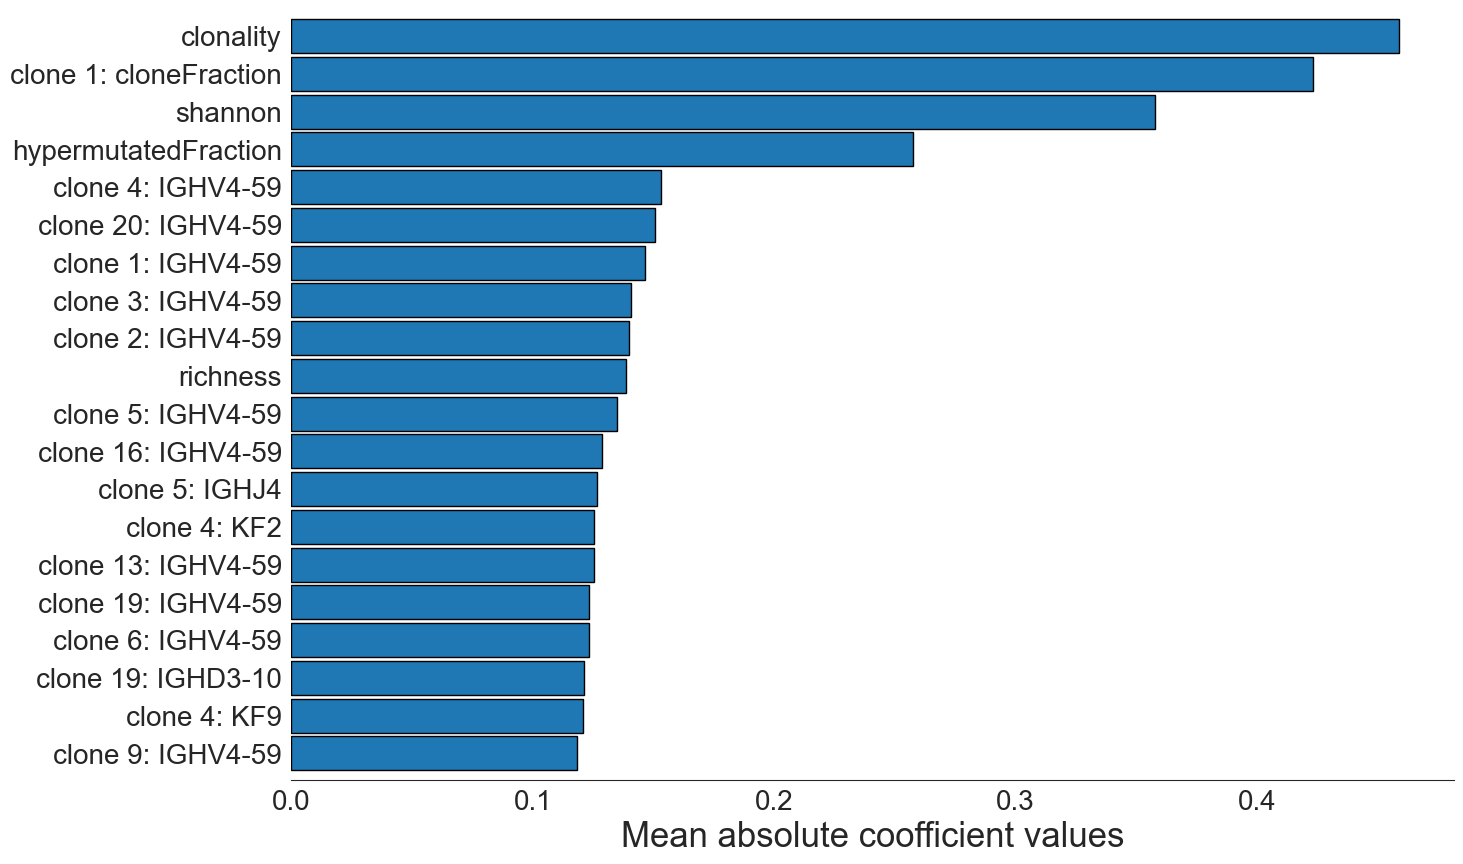

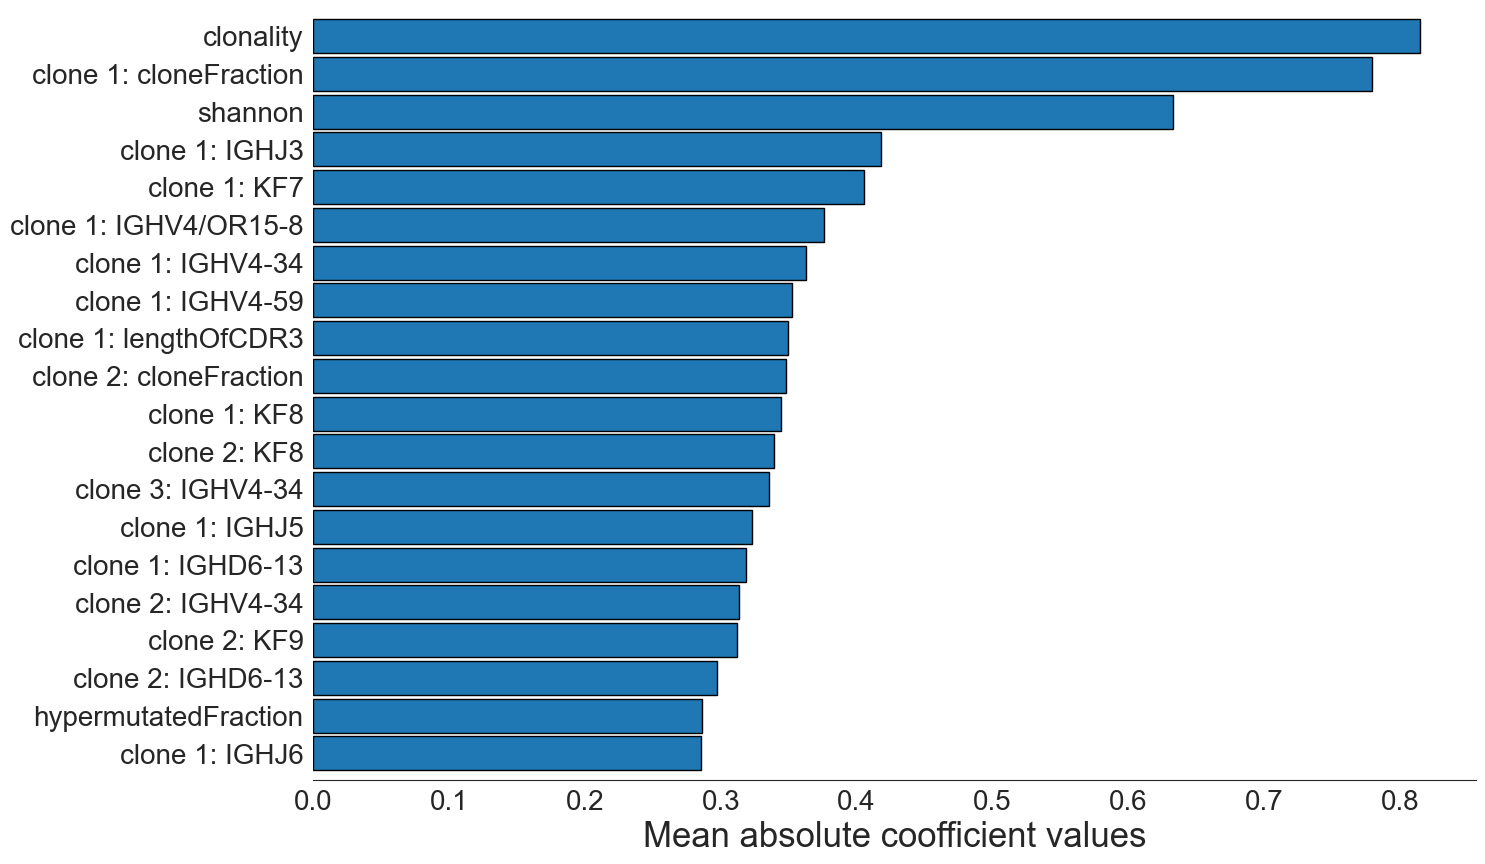

In [79]:
sns.set_style(style="white")
for condition in CONDITIONS:
    fig, ax = plt.subplots(figsize=(15,10))
    feature_importance = coef_per_condition[condition].copy()
    feature_importance["Coefficient"] = feature_importance["Coefficient"].apply(np.abs)
    feature_importance = feature_importance[['Feature', 'Coefficient']].groupby("Feature").mean().reset_index()
    feature_importance = feature_importance.sort_values('Coefficient', ascending=True)
    feature_importance.iloc[-20:].plot(x='Feature', y='Coefficient', kind='barh', ax=ax, edgecolor = "black", width=0.9) 
    
    ax.get_legend().remove()
    
    
    new_ticks = []
    for tick in ax.get_yticklabels():
        tick_text = tick.get_text()
        if "_" in tick_text:
            splitted = tick_text.split("_")
            clone = int(splitted[1]) + 1
            splitted = np.delete(splitted, 1)
            new_tick = "clone %s: " % clone + splitted[-1]#" ".join(splitted)             
            new_ticks.append(new_tick)
        else:
            new_ticks.append(tick_text)
    ax.set_yticklabels(list(new_ticks))
    ax.tick_params(axis='both', labelsize=20)
    ax.set_ylabel("",fontsize=25)
    if model == "RandomForest":
        ax.set_xlabel("Importance", fontsize=25)
    else:
        ax.set_xlabel("Mean absolute coefficient values", fontsize=25)
   
    ax.spines[['right', 'top','left']].set_visible(False)
    
        
    
    feature_importance["condition"] = condition
    best_feature_importance_df = pd.concat([best_feature_importance_df, feature_importance])
    if SAVE_PLOTS:
        plt.rcParams['svg.fonttype'] = 'none'
        plt.savefig('coefficient_magnitude_logistic_regression_%s.svg' % condition)

## Coefficient comparison per Class 

In [135]:
SAVE_PLOTS= True

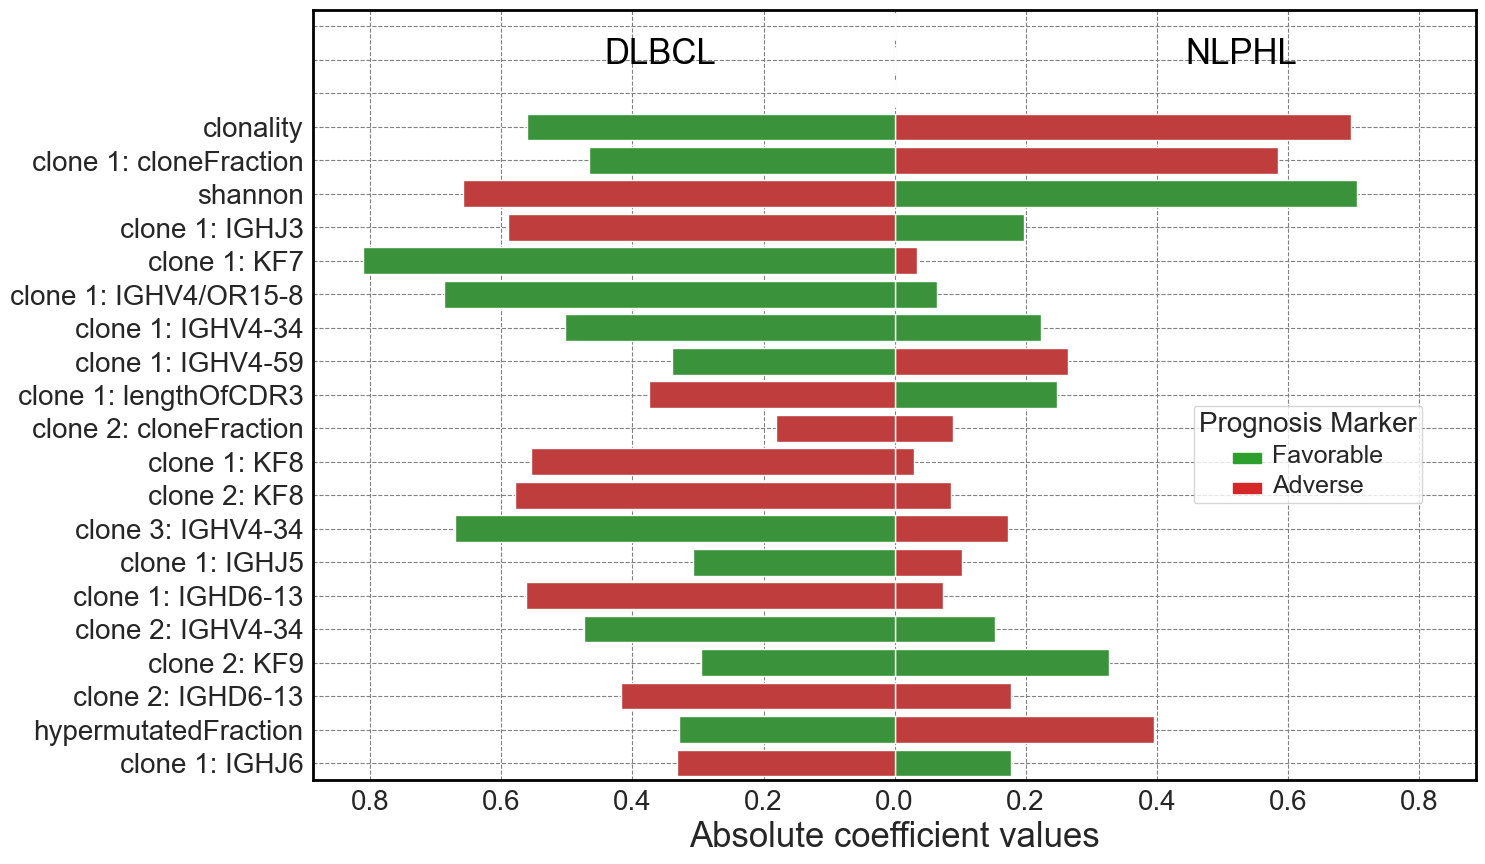

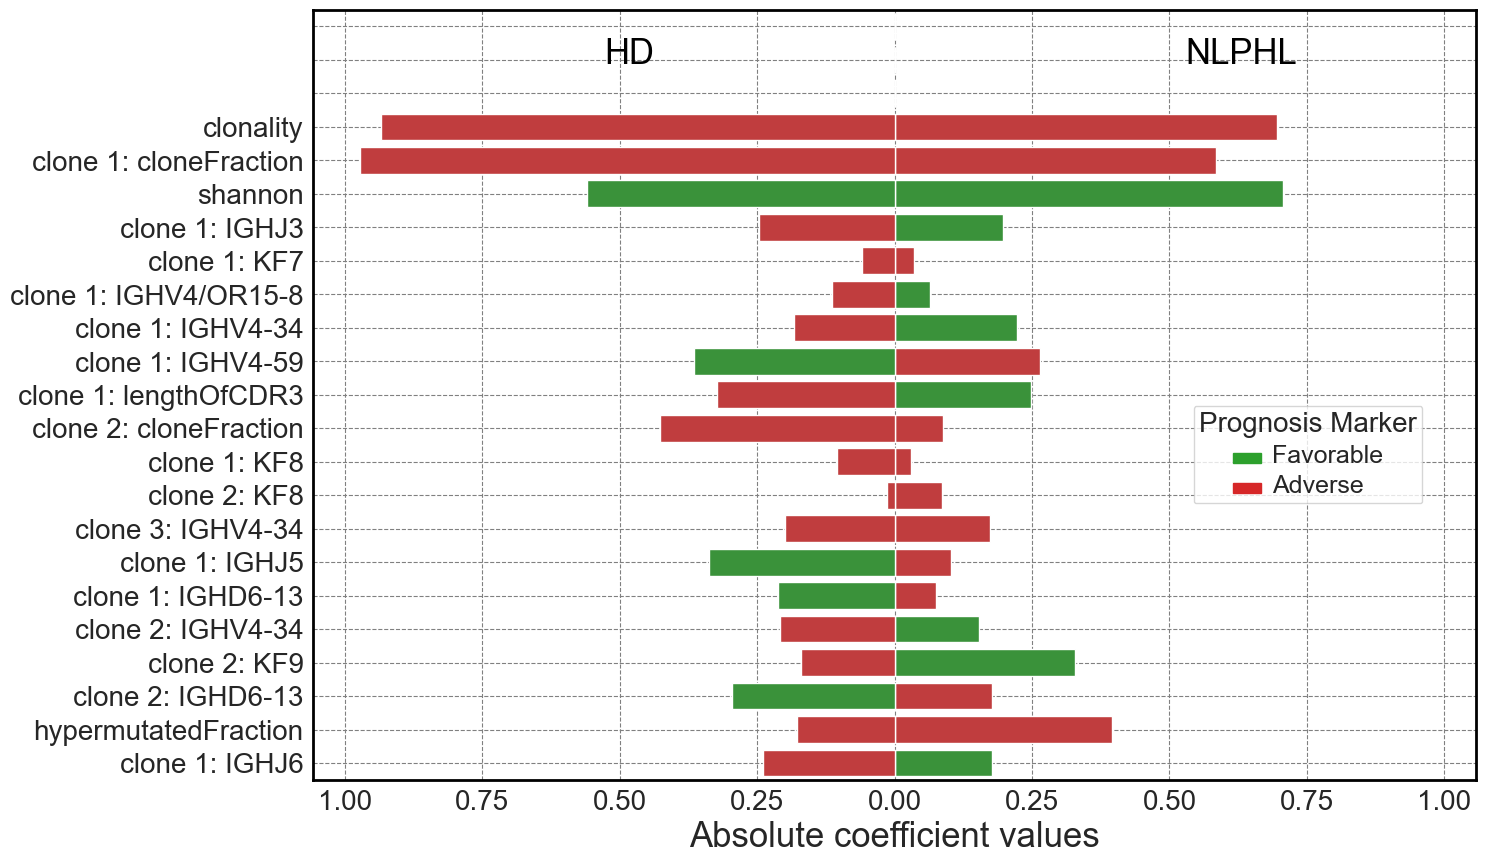

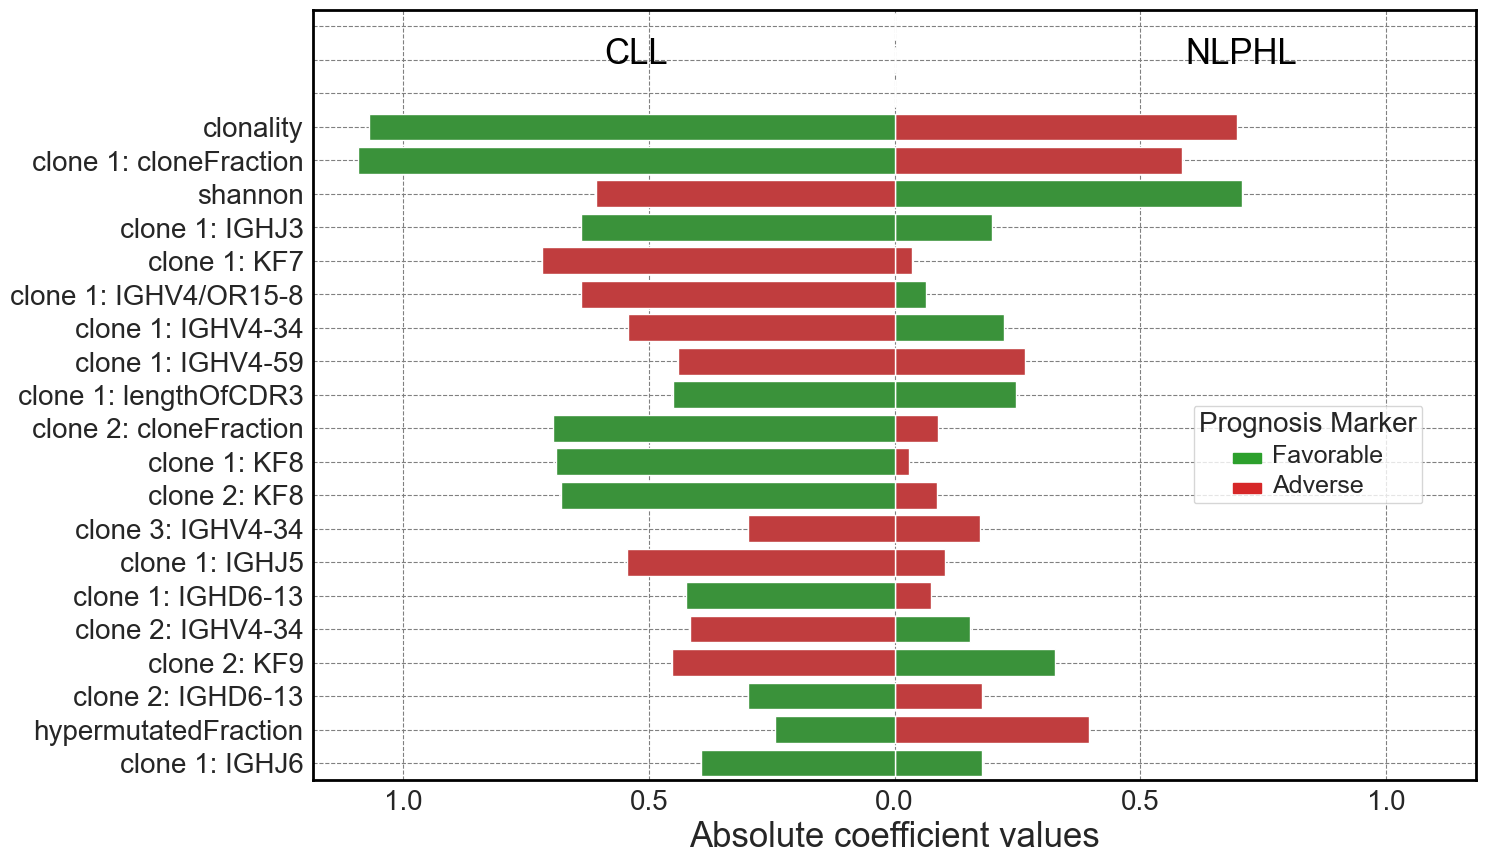

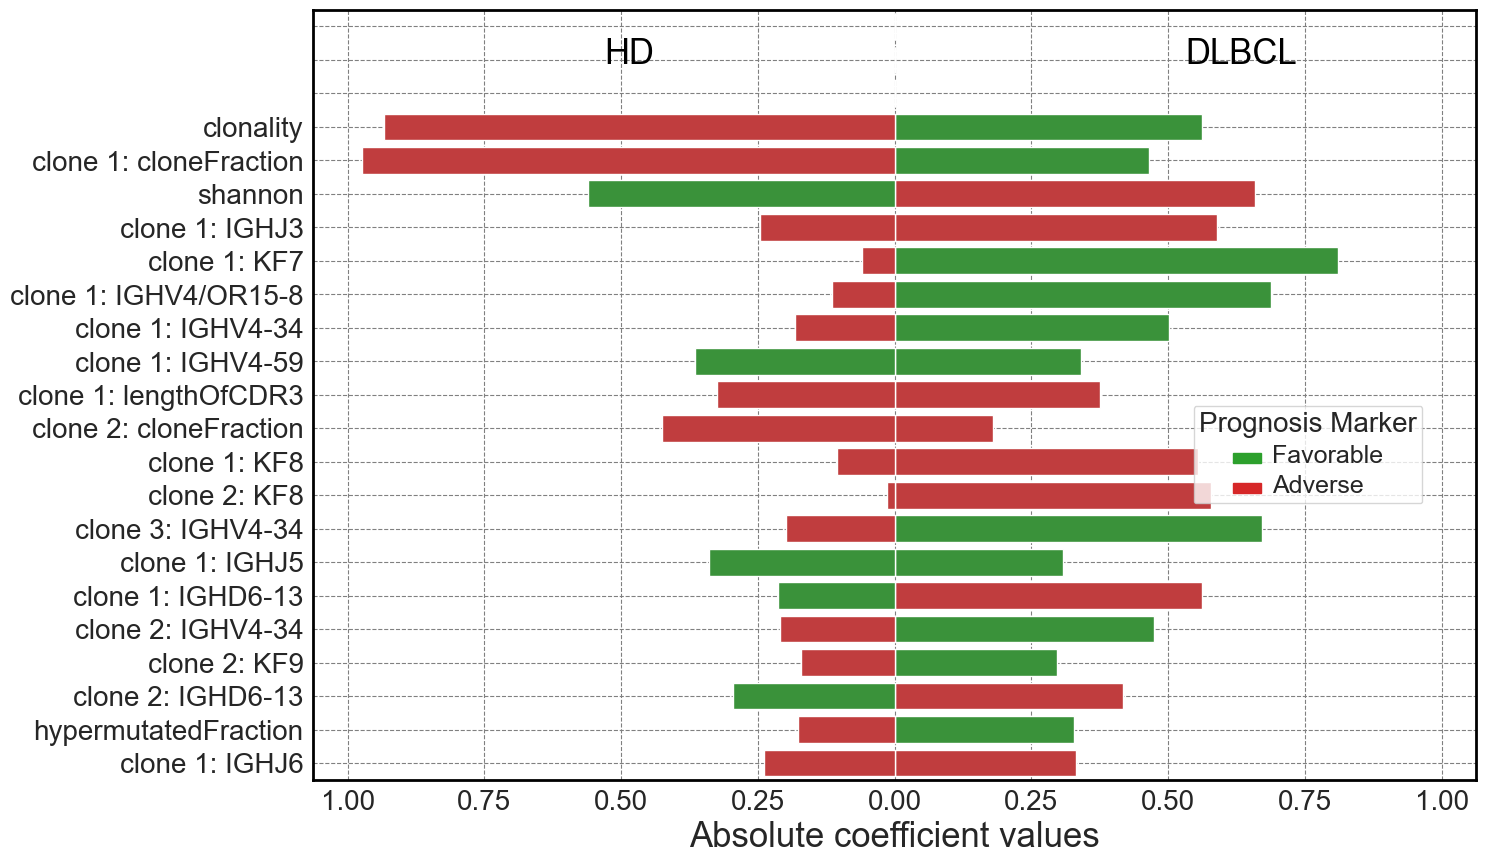

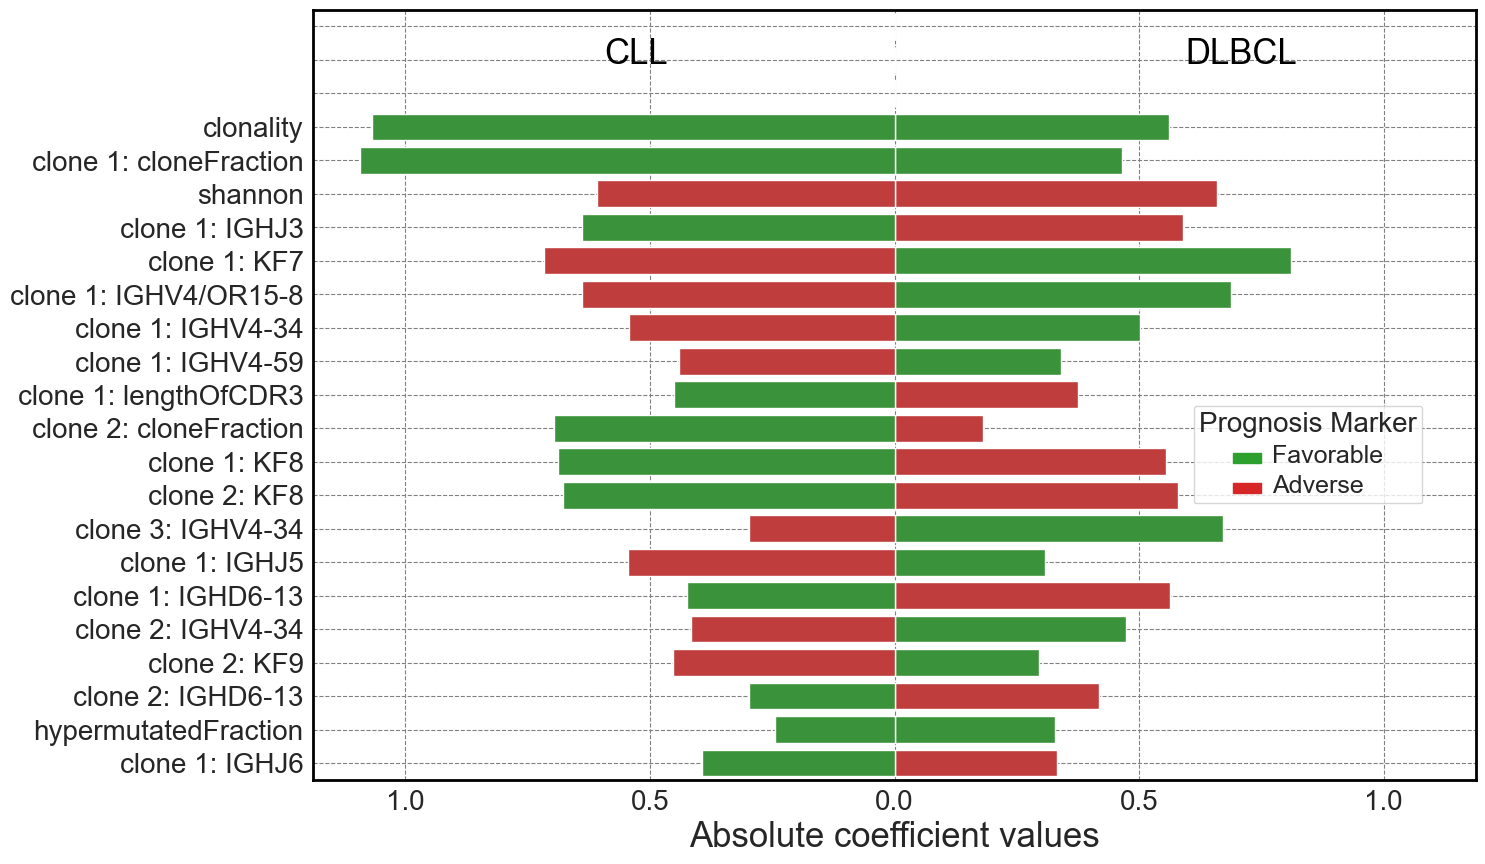

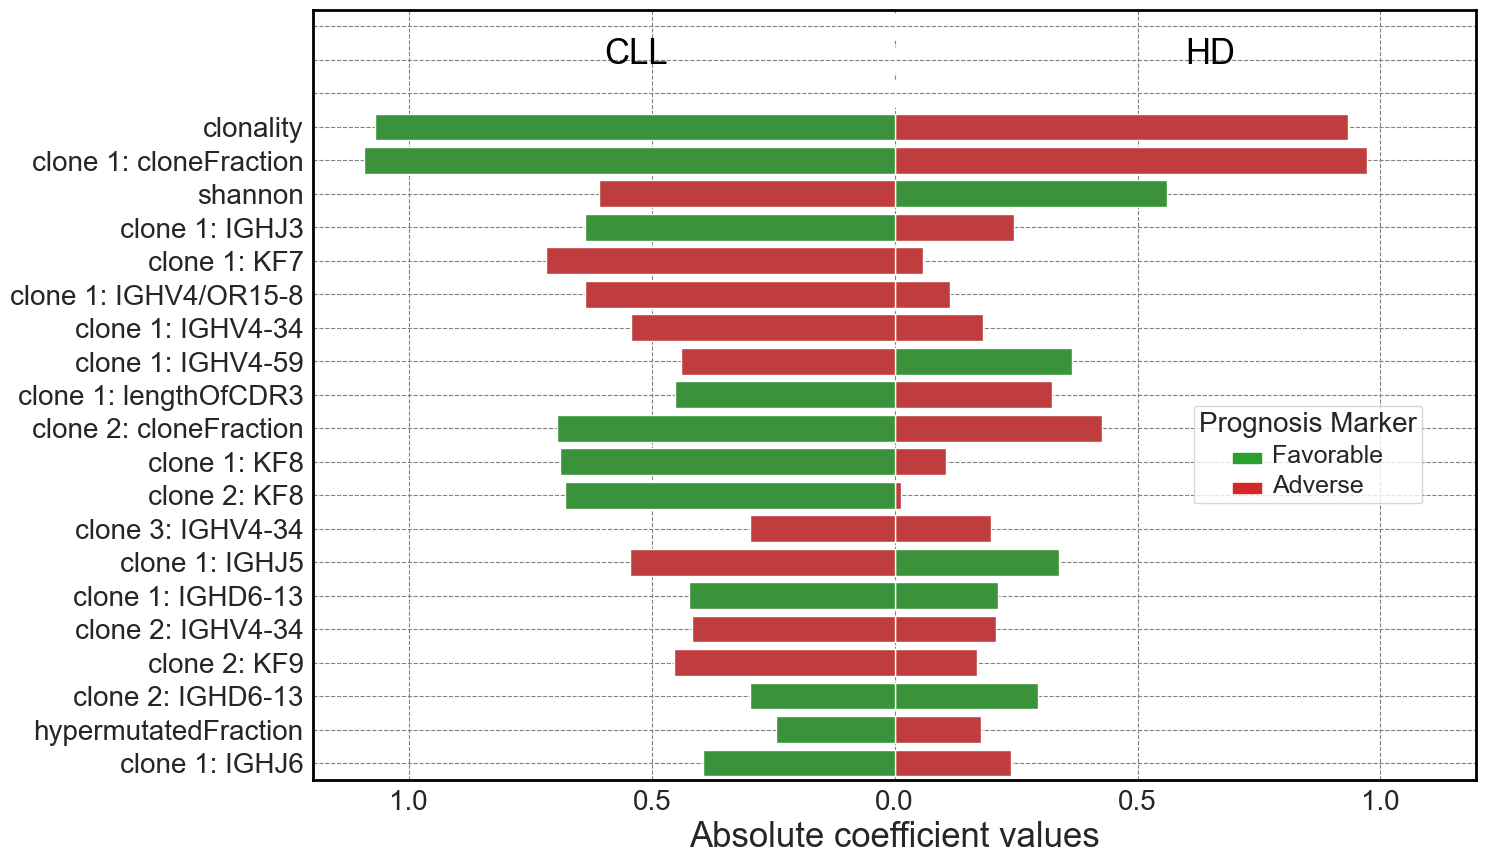

In [80]:
import itertools
SAVE_PLOTS = True
for condition in ["nlphl_dlbcl_hd_cll"]:
    feature_importance = coef_per_condition[condition].copy()
    feature_importance["Coefficient"] = feature_importance["Coefficient"].apply(np.abs)
    feature_importance = feature_importance[['Feature', 'Coefficient']].groupby("Feature").mean().reset_index()
    feature_importance = feature_importance.sort_values('Coefficient', ascending=True)
    
    top_n_features = list(feature_importance.iloc[-20:][::-1].Feature)
    df_cond = coef_per_condition[condition].copy()
    classes = df_cond.Class.unique()
    
    combinations = itertools.combinations(classes,2)
    for i, j in list(combinations):
        data_i = df_cond[df_cond["Class"] == i]
        data_j = df_cond[df_cond["Class"] == j]
        fig, ax = plt.subplots(figsize=(15,10))
        data_i_sorted = []
        data_j_sorted = []
        
        for feature in top_n_features:
            data_ = data_i[data_i.Feature == feature]
            data_i_sorted.append(data_)
            data_ = data_j[data_j.Feature == feature]
            data_j_sorted.append(data_)
            
        data_i_sorted = pd.concat(data_i_sorted)
        data_j_sorted = pd.concat(data_j_sorted)
        
        signs_i = np.sign(data_i_sorted.Coefficient)
        signs_j = np.sign(data_j_sorted.Coefficient)
        
        data_i_sorted["Coefficient"] = data_i_sorted["Coefficient"].apply(np.abs)
        data_j_sorted["Coefficient"] = -data_j_sorted["Coefficient"].apply(np.abs)
        
        colors_i = ["C2" if i==1 else "C3" for i in signs_i]
        colors_j = ["C2" if i==1 else "C3" for i in signs_j]
        
        d = []
        d.insert(0, {'Feature': "", 'Coefficient': 0, 'Class': None})
        d.insert(0, {'Feature': " ", 'Coefficient': 0, 'Class': None})
        d.insert(0, {'Feature': "  ", 'Coefficient': 0, 'Class': None})
        
        data_i_sorted = pd.concat([pd.DataFrame(d), data_i_sorted], ignore_index=True)
        data_j_sorted = pd.concat([pd.DataFrame(d), data_j_sorted], ignore_index=True)
        
        colors_i = ["C0", "C0", "C0"] + colors_i
        colors_j = ["C0", "C0", "C0"] + colors_j
        
        sns.barplot(y='Feature', x='Coefficient', orient = "h", ax=ax, data=data_i_sorted, palette=colors_i)
        sns.barplot(y='Feature', x='Coefficient', orient = "h", ax=ax, data=data_j_sorted, palette=colors_j)
        ax.yaxis.grid(color='gray', linestyle='dashed')
        ax.xaxis.grid(color='gray', linestyle='dashed')

        new_ticks = []
        for tick in ax.get_yticklabels():
            tick_text = tick.get_text()
            if "_" in tick_text:
                splitted = tick_text.split("_")
                clone = int(splitted[1]) + 1
                splitted = np.delete(splitted, 1)
                new_tick = "clone %s: " % clone + splitted[-1]#" ".join(splitted)             
                new_ticks.append(new_tick)
            else:
                new_ticks.append(tick_text)
        ax.set_yticklabels(list(new_ticks))
        ax.tick_params(axis='both', labelsize=20)
        ax.set_ylabel("",fontsize=25)
        ax.set_xlabel("Absolute coefficient values", fontsize=25)
        #ax.set_title(c)
        
        xmin, xmax = ax.get_xlim()
        xabs_max = max(np.abs(xmin), np.abs(xmax))
        ax.set_xlim((-xabs_max,+xabs_max))
        
        new_xticks = []
        for tick in ax.get_xticklabels():
            tick_text = tick.get_text()
            new_xticks.append(tick_text.replace("−", ""))
        ax.set_xticklabels(list(new_xticks))
        
        ax.spines[['right', 'top','left', 'bottom']].set_visible(True)
        for a in ['top','bottom','left','right']:
            ax.spines[a].set_linewidth(2)
            ax.spines[a].set_edgecolor("black")
            
        plt.annotate('%s' % i, xy=(0.75, 0.93), xycoords="axes fraction", color='Black', fontsize=25)
        plt.annotate('%s' % j, xy=(0.25, 0.93), xycoords="axes fraction", color='Black', fontsize=25)
        
        
        handles = [mpatches.Patch(color="C2", label="Favorable"),
                   mpatches.Patch(color="C3", label="Adverse")] 


        ax.legend(handles=handles, ncols=1, title = "Prognosis Marker", frameon=True, loc ="lower right")
        legend = ax.get_legend()
        legend.get_title().set_fontsize(20)  
        for label in legend.get_texts():
            label.set_fontsize(18)
        legend.set_bbox_to_anchor((0.96, 0.35, 0, 0.0))    
        
        if SAVE_PLOTS:
            plt.rcParams['svg.fonttype'] = 'none'
            plt.savefig('logisticRegression_coef_top_20_features_%s_%s_%s.svg' % (condition, i,j))
        
            

# PCA for n=1 to n=100 clones

In [82]:
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, color="C0", **kwargs):
    if ax is None:
        ax = plt.gca()

    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    width, height = 2 * nstd * np.sqrt(vals)
    ellipse = plt.matplotlib.patches.Ellipse(
        xy=pos, width=width, height=height, angle=theta, facecolor= "None", edgecolor=color, lw=3, ls="--", **kwargs
    )

    ax.add_patch(ellipse)

In [83]:
SAVE_PLOTS = True

Number of Class 1 repertoires: 90
Number of Class 2 repertoires: 182
Number of Class 3 repertoires: 291
Number of Class 4 repertoires: 348
(911, 111)
MANOVA nlphl_dlbcl_hd_cll 1 Clones:  5.089985525576381e-207
Eta-squared: 0.1051846122421829
Partial Eta-squared: 0.017492505499257065
(911, 225)
MANOVA nlphl_dlbcl_hd_cll 2 Clones:  1.349994567970381e-211
Eta-squared: 0.1098912475900039
Partial Eta-squared: 0.017789131976566713
(911, 331)
MANOVA nlphl_dlbcl_hd_cll 3 Clones:  5.180216541053567e-209
Eta-squared: 0.10822609090847113
Partial Eta-squared: 0.01762196205496505
(911, 435)
MANOVA nlphl_dlbcl_hd_cll 4 Clones:  5.934703901983444e-218
Eta-squared: 0.11091126274495444
Partial Eta-squared: 0.018196909472830564
(911, 545)
MANOVA nlphl_dlbcl_hd_cll 5 Clones:  1.7978325554292416e-237
Eta-squared: 0.11638103983536308
Partial Eta-squared: 0.01941874311243703
(911, 1076)
MANOVA nlphl_dlbcl_hd_cll 10 Clones:  5.734655856591871e-262
Eta-squared: 0.1231453623852331
Partial Eta-squared: 0.020890

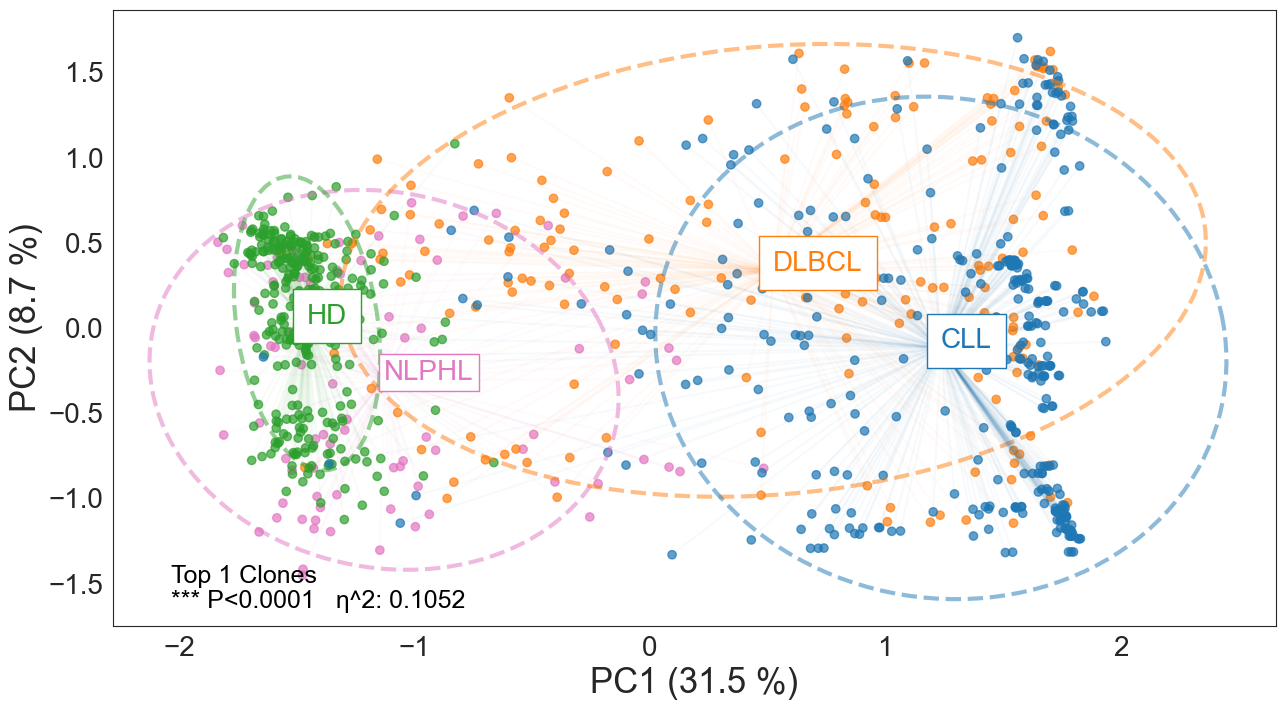

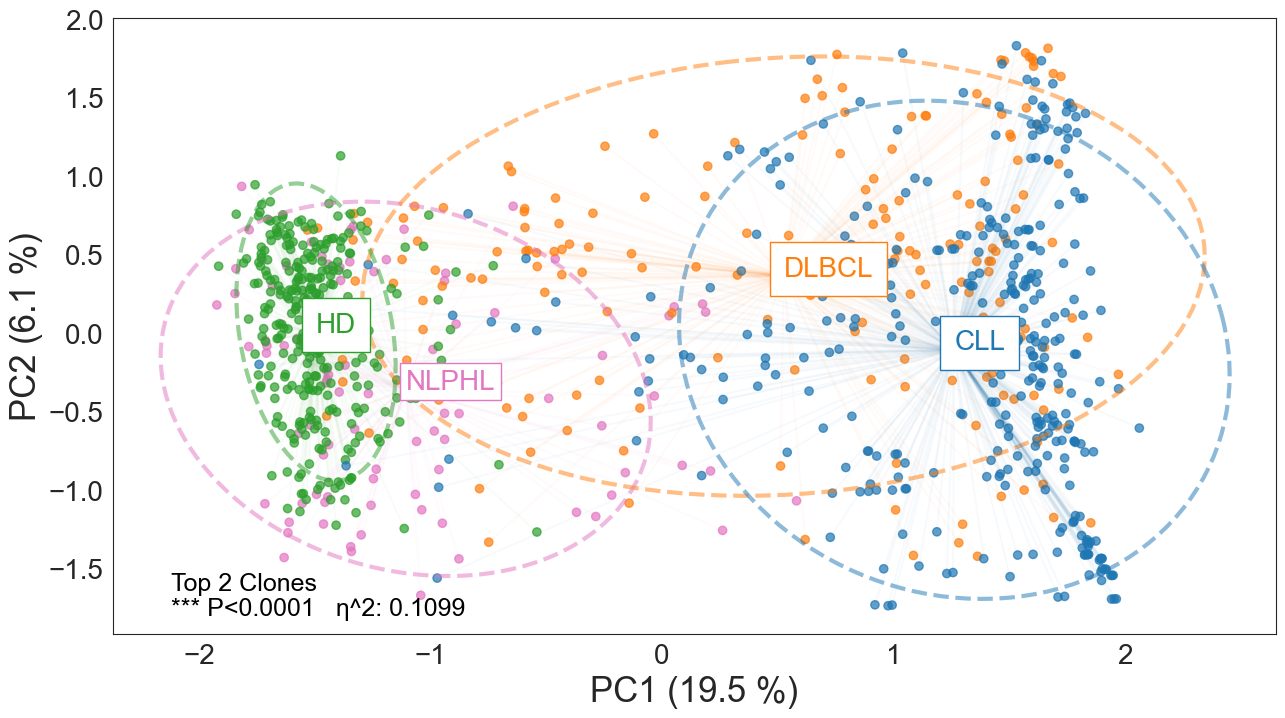

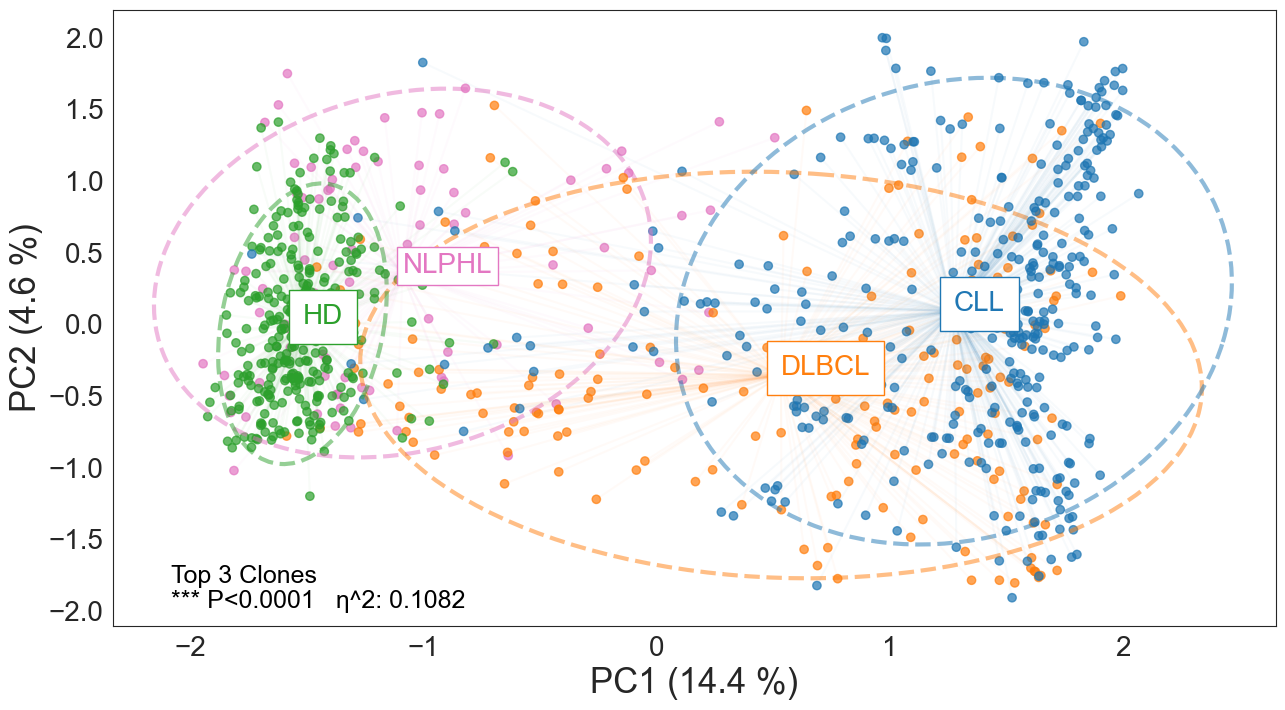

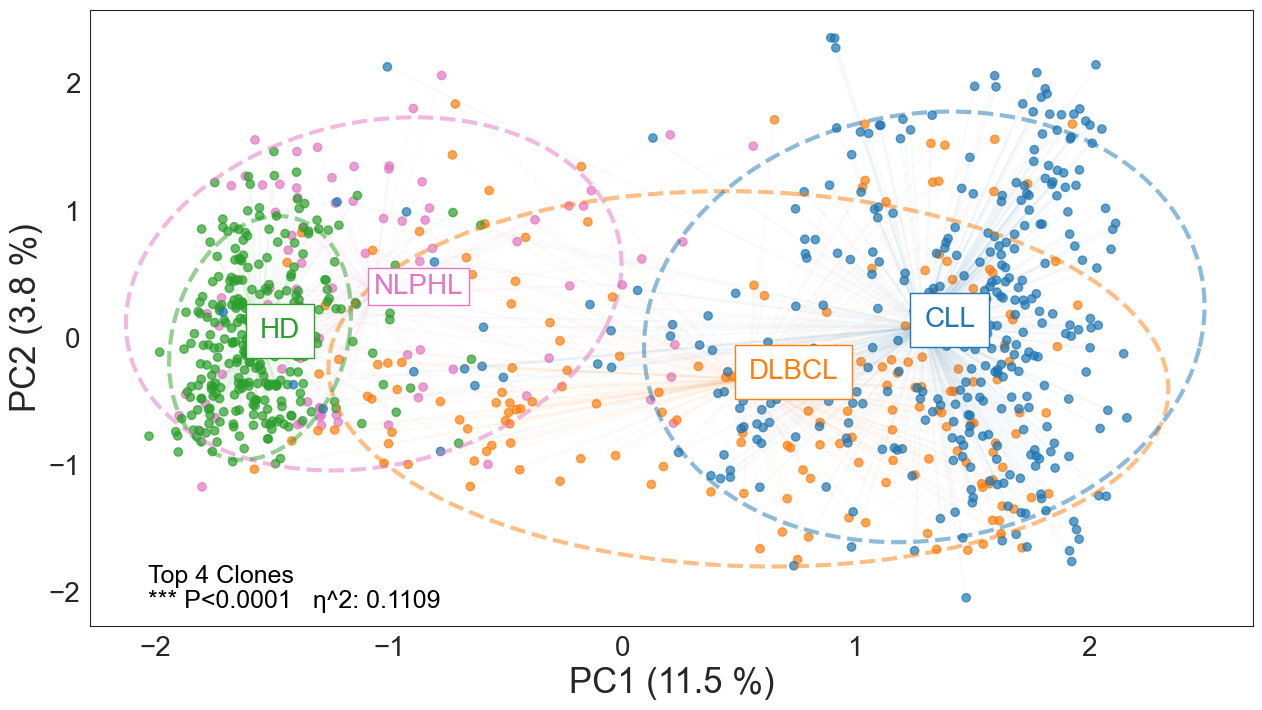

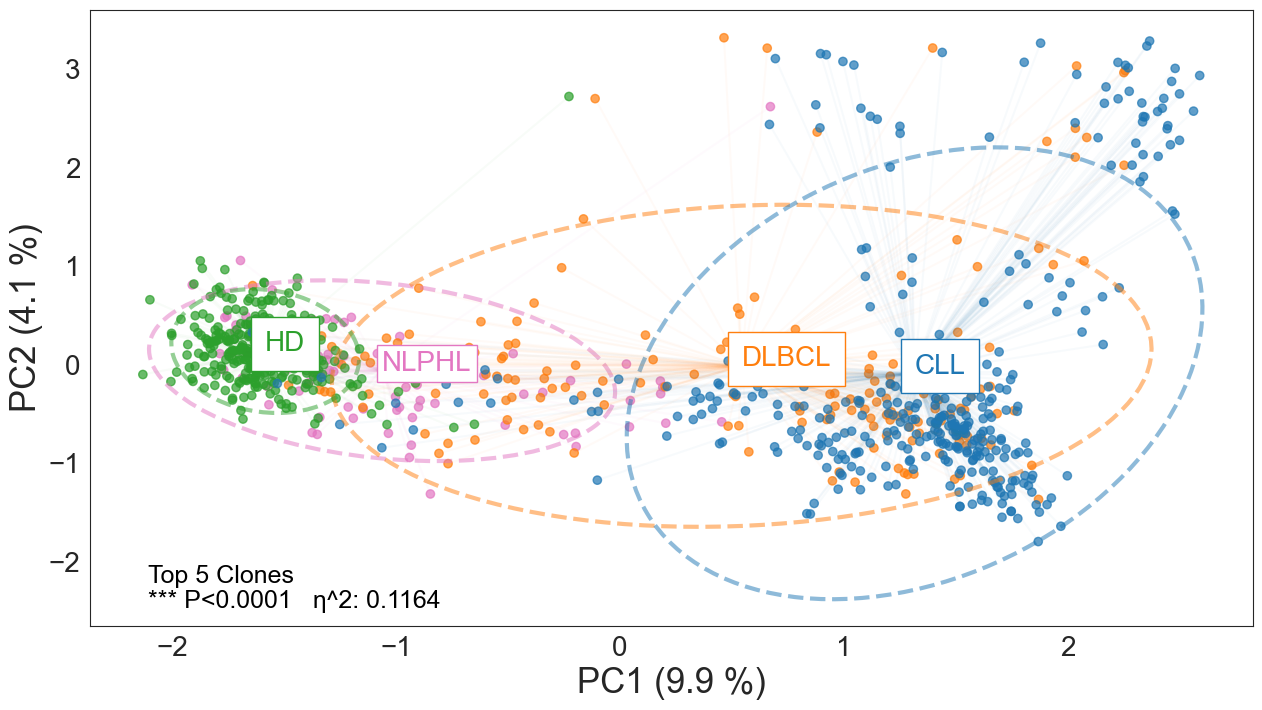

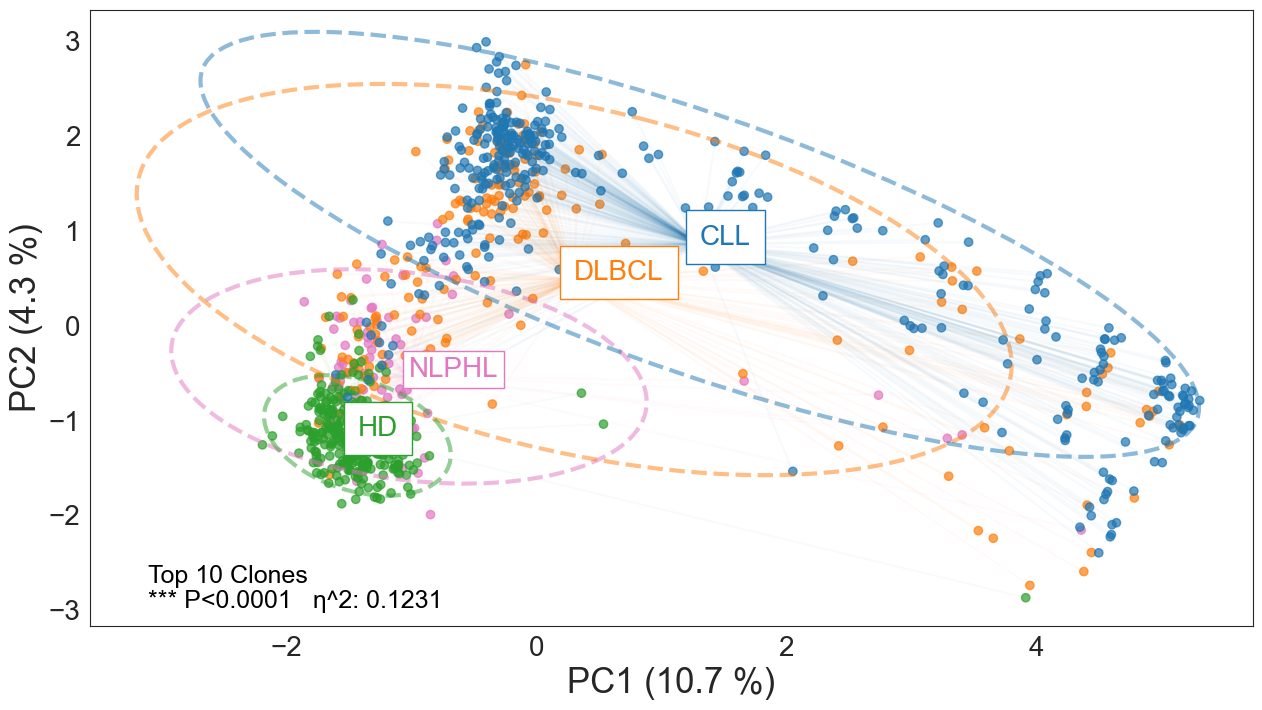

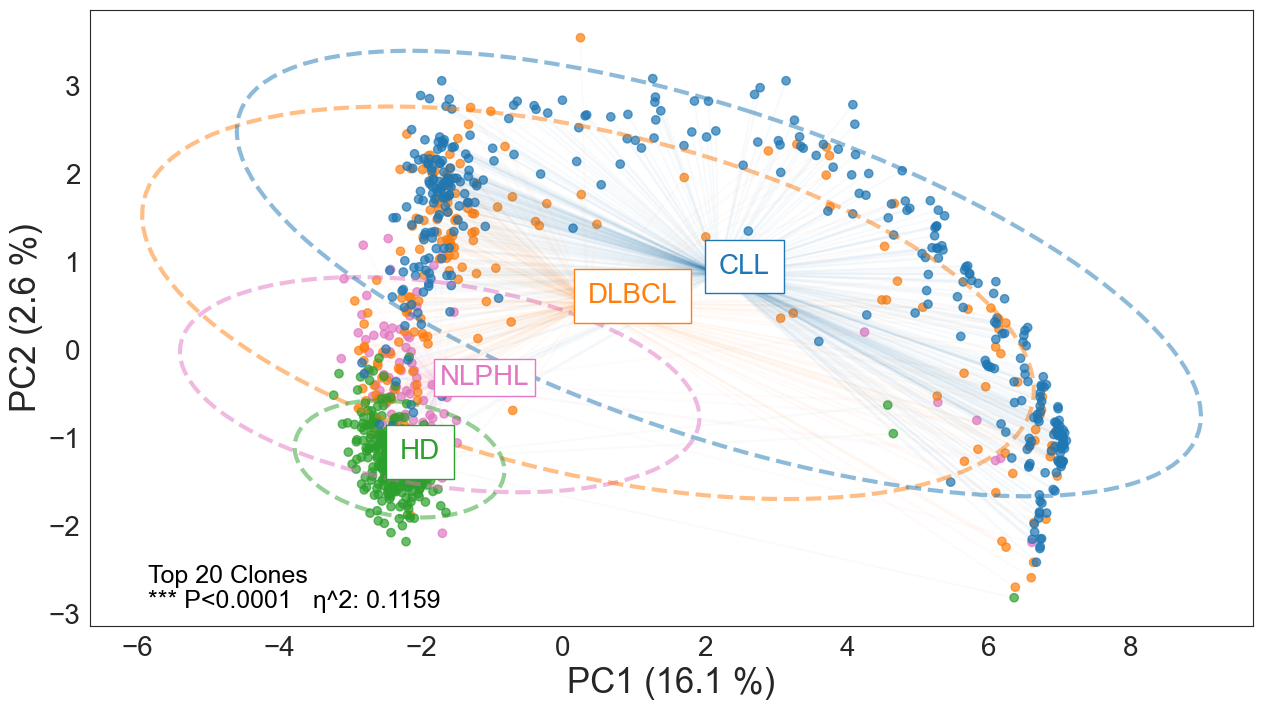

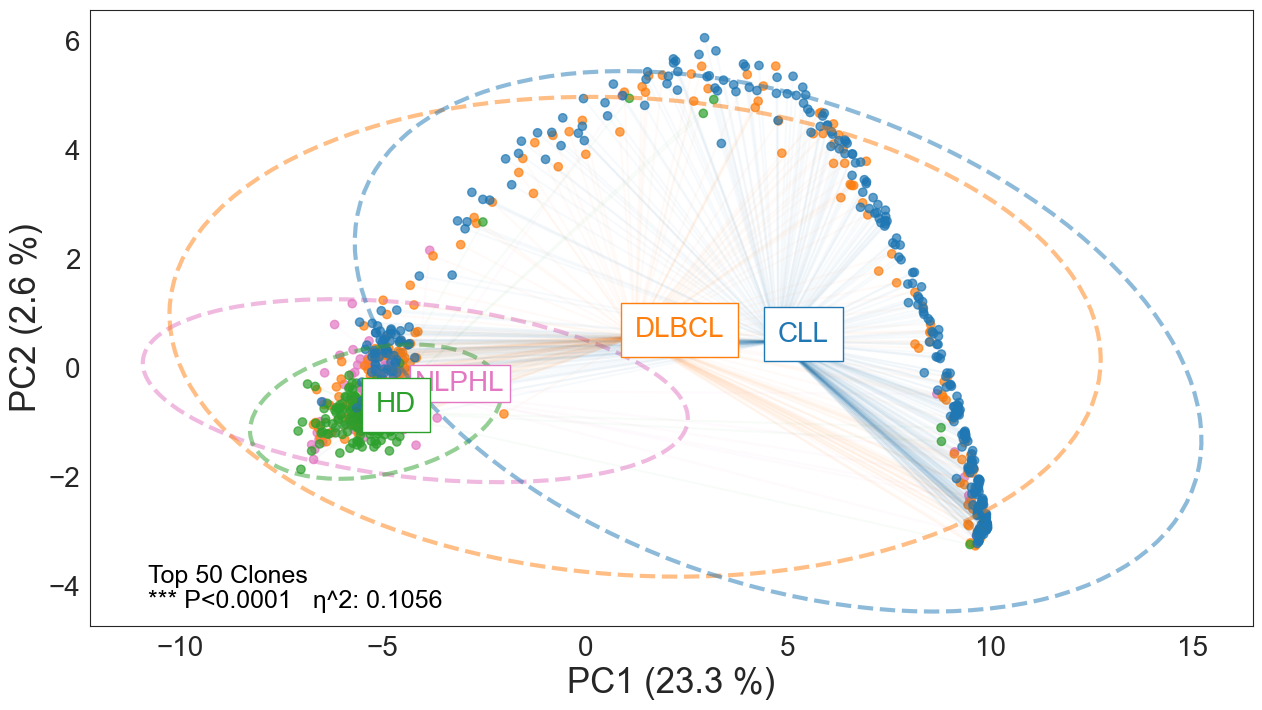

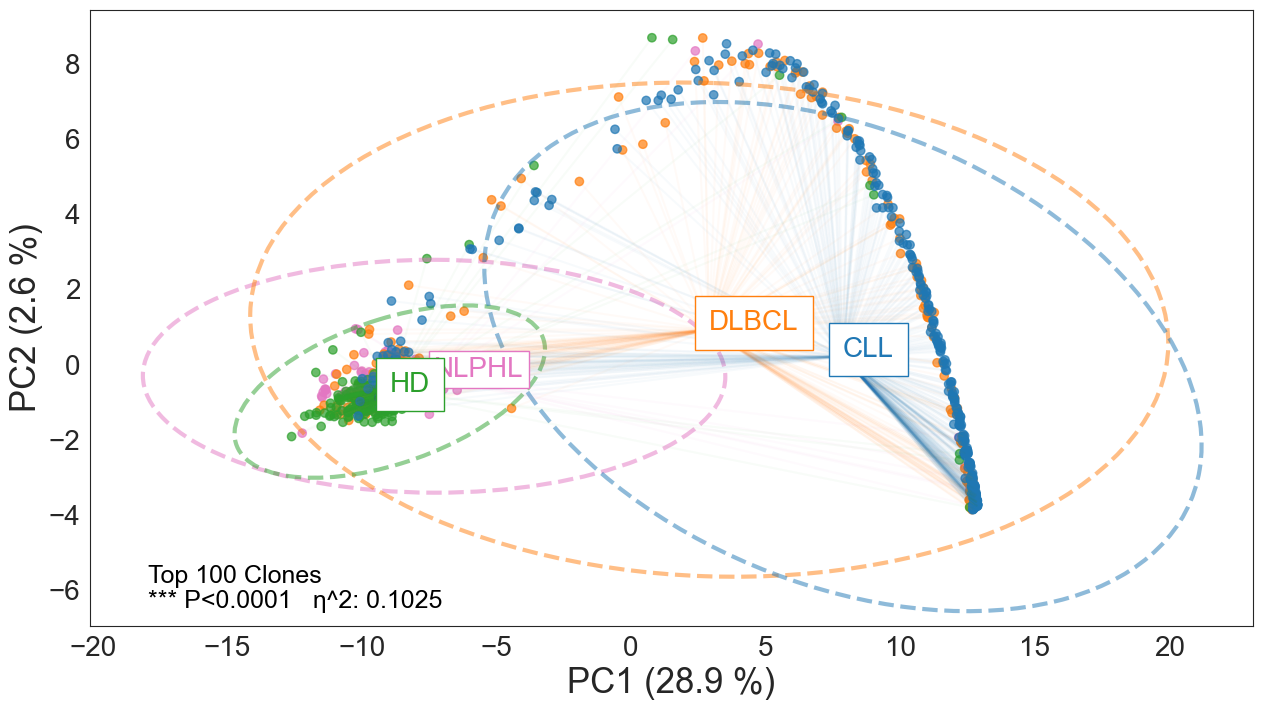

In [84]:
sns.set_style(style="white")

path_dir = "data/"
selected_features = ['cloneFraction', 'lengthOfCDR3']  + ['bestVGene', 'bestDGene', 'bestJGene'] + ['KF%i' %i for i in range(1, 11)]
selected_features += ["clonality"] 
selected_features += ["richness"]
selected_features += ["shannon"]
selected_features += ["hypermutatedFraction"]

feature_names = ['cloneFraction', 'lengthOfCDR3', 'clonality', 'shannon', 'richness', 'hypermutatedFraction']  + ['bestVGene', 'bestDGene', 'bestJGene'] + ['KF%i' %i for i in range(1, 11)] 
object_types = ['float64', 'int64', 'float64', 'float64', 'float64', 'float64']  +  ['object', 'object', 'object']+['float64' for i in range(10)] 

feature_dict = {}
for i in range(len(feature_names)):
    feature_dict[feature_names[i]] = object_types[i]

selected_object_types = [feature_dict[feature] for feature in selected_features]


for condition in ["nlphl_dlbcl_hd_cll"]:
    df_best_condition = df_best[df_best.condition == condition]
    comparisons = cond_comparison_dict[condition]
    comparisons_labels = cond_labels_dict[condition]
        
    class_files, number_of_repertoires = run_classical.load_metadata(comparisons, "IGH", path_dir)
    
    
    for n in [1,2,3,4,5,10,20,50,100]:
        X, Y, clone_fractions = run_classical.create_features(class_files, 
                                                selected_features, 
                                                selected_object_types, 
                                                n, 
                                                onehot_encoding=True, 
                                                ordinal_encoding=False, 
                                                standardize=True, 
                                                genefamily=False)
        
        print(X.shape)
        
        low_dlbcl_mask =np.array([1 if ((cf < 0.2) & (Y[i] == 1)) else 0 for i, cf in enumerate(clone_fractions)])
        low_dlbcl_mask = low_dlbcl_mask == 1
        
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
        train_index, test_index =  sss.split(X, Y).__next__()

        X_test = X.iloc[np.sort(test_index)]
        Y_test = Y[np.sort(test_index)]

    
        label_color_mapping = {"CLL" : "C0", "DLBCL" : "C1", "HD" : "C2", "NLPHL" : "C6"}
        labels = [comparisons_labels[i] for i in Y]
        colors = [label_color_mapping[l] for l in labels]
        
        labels_test = [comparisons_labels[i] for i in Y_test]
        colors_test = [label_color_mapping[l] for l in labels_test]

        l, c = np.unique(Y, return_counts = True)
        idxs = np.cumsum(c) # idxs for class in X 
    

        n_components = 5
        pca = PCA(n_components=n_components)
        
        
        X_pca = pca.fit_transform(X)
        X_test_pca = pca.transform(X_test)
        
        fig, ax = plt.subplots(figsize=(15,8))
        ax.scatter(X_pca[:,0],X_pca[:,1],color=colors, alpha=0.7)
        
        centroids = []

        for i, idx in enumerate(idxs): # iterate over classes and calculate centroid
            if i == 0:
                centroid = np.mean(X_pca[0:idx,:], axis=0)
                centroids.append(centroid)

                x = X_pca[0:idx,0]
                y = X_pca[0:idx,1]

                for xx, yy, in zip(x, y):
                    ax.plot([centroid[0], xx], [centroid[1], yy], color = label_color_mapping[comparisons_labels[i]], alpha = 0.03)
                
                ax.text(centroid[0], centroid[1], comparisons_labels[i], color= label_color_mapping[comparisons_labels[i]], fontsize=20, 
                bbox=dict(facecolor='white', edgecolor=label_color_mapping[comparisons_labels[i]]))
                
                
                
                class_data = X_pca[0:idx,:2]
                confidence_level = 0.8
                nstd = np.sqrt(chi2.ppf(confidence_level, 2))
                cov_class = np.cov(class_data, rowvar=False)
                mean_class = np.mean(class_data, axis=0)

                plot_cov_ellipse(cov_class, mean_class, nstd=nstd, ax=ax, alpha=0.5, color = label_color_mapping[comparisons_labels[i]])
                
                
            else:
                centroid = np.mean(X_pca[idxs[i-1]:idx,:], axis=0)
                centroids.append(centroid)

                x = X_pca[idxs[i-1]:idx,0]
                y = X_pca[idxs[i-1]:idx,1]

                for xx, yy, in zip(x, y):
                    ax.plot([centroid[0], xx], [centroid[1], yy], color = label_color_mapping[comparisons_labels[i]], alpha = 0.03)

                ax.text(centroid[0], centroid[1], comparisons_labels[i], color= label_color_mapping[comparisons_labels[i]], fontsize=20, 
                bbox=dict(boxstyle='square,pad=0.5', facecolor='white', edgecolor=label_color_mapping[comparisons_labels[i]]))
                
                
                class_data = X_pca[idxs[i-1]:idx,:2]
                confidence_level = 0.8
                nstd = np.sqrt(chi2.ppf(confidence_level, 2))
                cov_class = np.cov(class_data, rowvar=False)
                mean_class = np.mean(class_data, axis=0)

                plot_cov_ellipse(cov_class, mean_class, nstd=nstd, ax=ax, alpha=0.5, color = label_color_mapping[comparisons_labels[i]])
                

        explained_variance_ratio = pca.explained_variance_ratio_
        ax.tick_params(axis='both', labelsize=20)
        ax.set_ylabel("PC2 (%.1f %%)" % (explained_variance_ratio[1]*100),fontsize=25)
        ax.set_xlabel("PC1 (%.1f %%)" % (explained_variance_ratio[0]*100), fontsize=25)
        
        
    
        pca_df = pd.DataFrame({"Class": [comparisons_labels[i] for i in Y]})
        pca_df["Class"] = pca_df["Class"].astype('category')
        formula = []
        for i in range(X_pca.shape[1]):
            pca_df["PC%d" % (i+1)] = X_pca[:,i]
            formula.append("PC%d" % (i+1))
        
        formula = "+".join(formula) + "~ Class"
        manova = MANOVA.from_formula(formula, data=pca_df)
        fit = pd.DataFrame((manova.mv_test().results['Class']['stat']))
        p_value = fit['Pr > F']["Pillai's trace"]
        print("MANOVA %s %s Clones: " % (condition,n), p_value)   
        
        manova_results = manova.mv_test()

        wilks_lambda = manova_results.summary_frame.loc["Class"].loc["Wilks' lambda"].Value

        # Calculate degrees of freedom
        num_groups = len(np.unique(labels))
        num_dep_vars = X_pca.shape[1]
        num_total_obs = len(X_pca)

        df_effect = num_dep_vars * (num_groups - 1)
        df_residual = num_total_obs - num_groups

        # Eta-squared for the overall model
        eta_squared = 1 - (wilks_lambda ** (1 / df_effect))
        
        # Calculate the partial eta squared (ηp²)
        squared_pillai = manova_results.results["Class"]['stat'].loc["Pillai's trace"].Value
        df2 = (num_dep_vars * (num_groups - 1) * (num_dep_vars + 2)) / 2
        partial_eta_squared = squared_pillai / (squared_pillai + df2)

        print("Eta-squared:", eta_squared)
        print("Partial Eta-squared:", partial_eta_squared)
        
        
       
        if p_value < 0.001:
            if p_value < 0.0001:
                sig_symbol = '*** P<0.0001'
            else:
                sig_symbol = '*** P<0.001'
        elif p_value < 0.01:
            sig_symbol = '** P<0.01'
        elif p_value < 0.05:
            sig_symbol = '* P<0.05'
        else:
            sig_symbol = "P>0.05"
        
        
        ax.spines[['right', 'top','left', 'bottom']].set_visible(True)
            
        plt.annotate('Top %s Clones' % n, xy=(0.05, 0.07), xycoords="axes fraction", color='Black', fontsize=18)
        plt.annotate(sig_symbol + f'   η^2: {eta_squared:.4f}', xy=(0.05, 0.03), xycoords="axes fraction", color='Black', fontsize=18)
        
        
        if SAVE_PLOTS:
            plt.rcParams['svg.fonttype'] = 'none'
            plt.savefig('pca_%s_top_%d_clones.svg' % (condition,n))


# General Distribution Plots

In [4]:
cond_lymphom_dict = {'cll_dlbcl_hd': ["cll", "dlbcl", "gcb_dlbcl", "abc_dlbcl", "hd"],
                    'nlphl_dlbcl_hd': ["nlphl", "dlbcl", "gcb_dlbcl", "abc_dlbcl", "hd"],
                    'nlphl_dlbcl_hd_cll': ["nlphl", "dlbcl", "gcb_dlbcl", "abc_dlbcl", "hd", "cll"]}

In [5]:
cond_comparison_dict = {
    "cll_dlbcl_hd" : [['cll'], ["dlbcl", "gcb_dlbcl", "abc_dlbcl"], ['hd']],
    "nlphl_dlbcl_hd" : [['nlphl'], ["dlbcl", "gcb_dlbcl", "abc_dlbcl"], ['hd']],
    "nlphl_dlbcl_hd_cll" : [['nlphl'], ["dlbcl", "gcb_dlbcl", "abc_dlbcl"], ['hd'], ["cll"]]
}

In [6]:
cond_labels_dict = {
    "cll_dlbcl_hd" : ['CLL', 'DLBCL', 'HD'],
    "nlphl_dlbcl_hd" : ['NLPHL', 'DLBCL', 'HD'],
    "nlphl_dlbcl_hd_cll" : ['NLPHL', 'DLBCL', 'HD', 'CLL']
}

In [8]:
path_dir = "data/"
comparisons = cond_comparison_dict["nlphl_dlbcl_hd_cll"]
comparisons_labels = cond_labels_dict["nlphl_dlbcl_hd_cll"]

selected_features = ['cloneFraction', 'lengthOfCDR3']  + ['bestVGene', 'bestDGene', 'bestJGene'] + ['KF%i' %i for i in range(1, 11)]
selected_features += ["clonality"] 
selected_features += ["richness"]
selected_features += ["shannon"]
selected_features += ["vBestIdentityPercent"]


feature_names = ['cloneFraction', 'lengthOfCDR3', 'clonality', 'shannon', 'richness', 'vBestIdentityPercent']  + ['bestVGene', 'bestDGene', 'bestJGene'] + ['KF%i' %i for i in range(1, 11)] 
object_types = ['float64', 'int64', 'float64', 'float64', 'float64', 'float64']  +  ['object', 'object', 'object']+['float64' for i in range(10)]
# create dict from feature name to object type
feature_dict = {}
for i in range(len(feature_names)):
    feature_dict[feature_names[i]] = object_types[i]

selected_object_types = [feature_dict[feature] for feature in selected_features]


class_files, number_of_repertoires = run_classical.load_metadata(comparisons, "IGH", path_dir)
X, Y, clone_fractions, filenames = run_classical.create_features(class_files, 
                                                selected_features, 
                                                selected_object_types, 
                                                1, 
                                                onehot_encoding=True, 
                                                ordinal_encoding=False, 
                                                standardize=False, 
                                                genefamily=False,return_filenames=True)

Number of Class 1 repertoires: 90
Number of Class 2 repertoires: 182
Number of Class 3 repertoires: 291
Number of Class 4 repertoires: 348


In [15]:
with open('immusign_used_files.txt', 'w') as f:
    for group in filenames:
        for file in group:
            f.write(file[0] + "\n")

In [72]:
class_number_df = pd.DataFrame({"Class" : comparisons_labels, "Samples" : [90, 182, 291, 348]})

In [74]:
custom_order = ['HD', 'NLPHL', 'DLBCL', 'CLL']

# Create a custom sorting key based on the order
sorting_key = class_number_df['Class'].map(lambda x: custom_order.index(x))

# Sort the DataFrame based on the custom sorting key
class_number_df = class_number_df.iloc[sorting_key.argsort()]

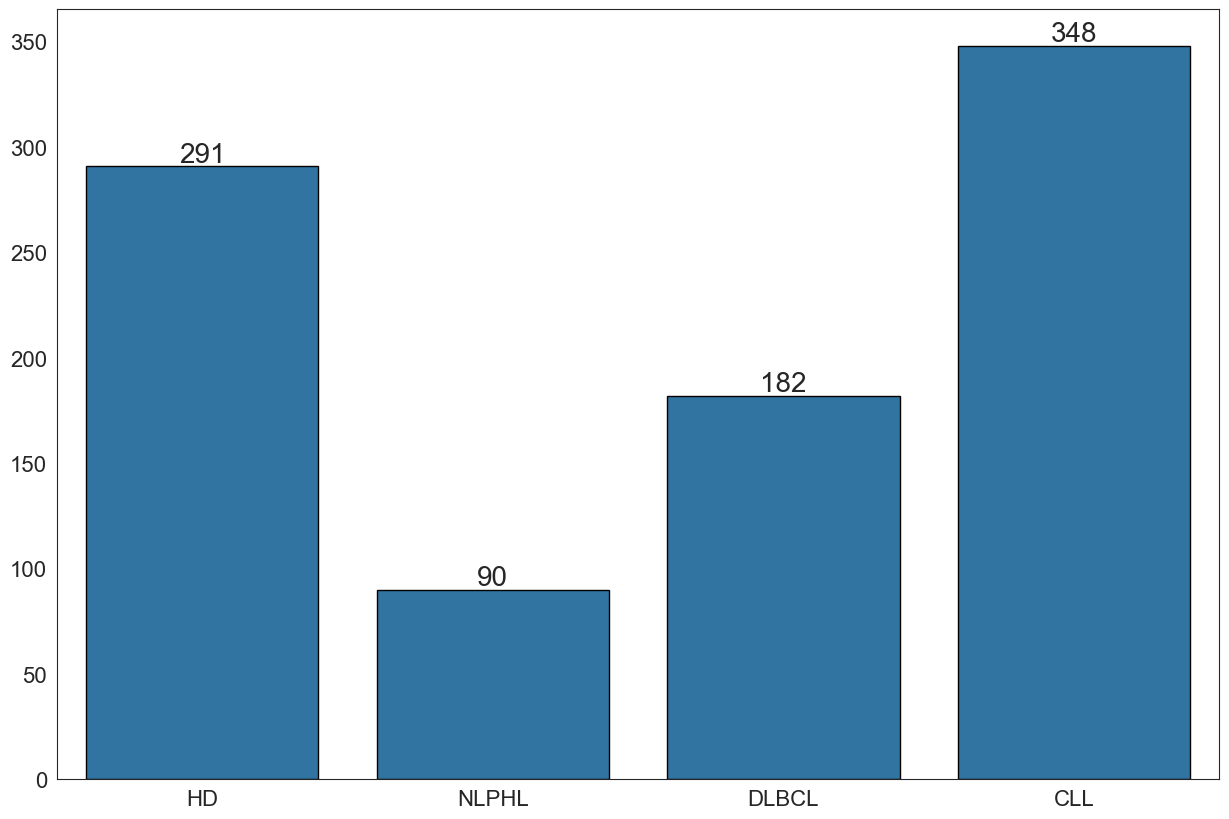

In [75]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.barplot(x='Class', y='Samples', data = class_number_df, ax=ax, edgecolor = "black", color="C0") 
ax.tick_params(axis='both', labelsize=16)
ax.set_ylabel("",fontsize=18)
ax.set_xlabel("", fontsize=18)
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
#ax.get_legend().remove()

for i, v in enumerate(class_number_df["Samples"]):
    ax.text(i, v + 2, str(v), ha='center', fontsize=20)


In [76]:
X["Class"] = [comparisons_labels[i] for i in Y]

In [77]:
sorting_key = X['Class'].map(lambda x: custom_order.index(x))
X = X.iloc[sorting_key.argsort()]

# Richness Clonality Diversity

In [80]:
SAVE_PLOTS = False

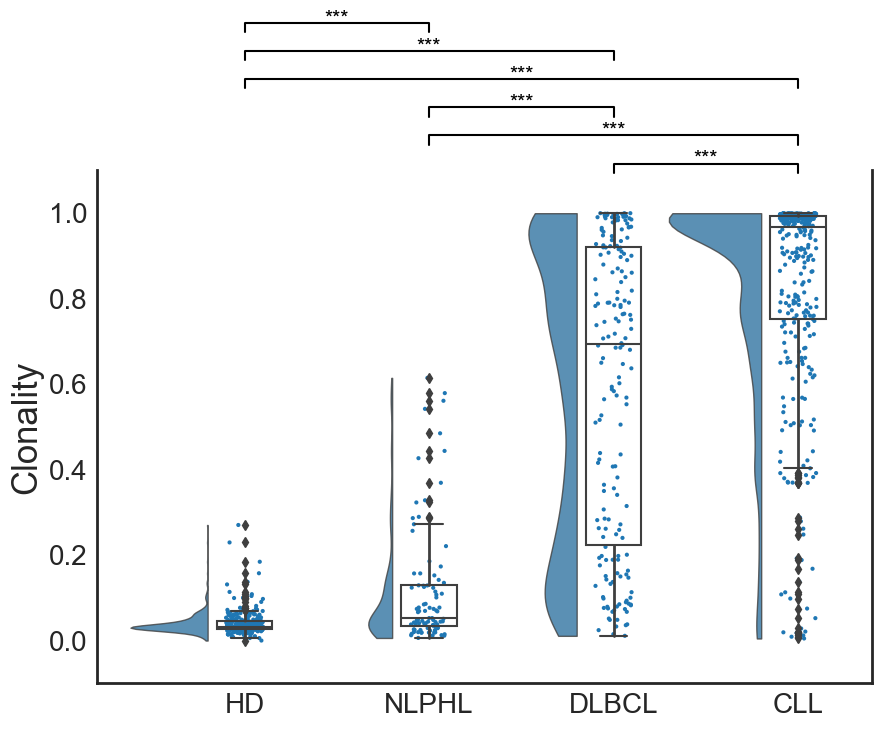

In [143]:
fig, ax = plt.subplots(figsize=(10,6.66))
#sns.violinplot(data=X, x="Class", y="clonality", ax=ax, width = 0.9, color="C0", scale="count", cut=0)
#sns.swarmplot(x ='Class', y ='clonality', data=X, color= "black", alpha=0.4)
pt.RainCloud(x = "Class", y = "clonality", data = X,scale = "count", cut=0,
                     width_viol = 1, width_box=0.3, offset=0.2,ax = ax, pointplot = False, 
             alpha = .8, dodge = True, palette=["C0"])


significant_combinations = []
classes = X.Class.unique()
class_index_dict  = {}
for i,c in enumerate(classes):
    class_index_dict[c] = i
combinations = itertools.combinations(classes,2)
for i, j in list(combinations):
    data1 = X[X.Class == i].clonality
    data2 = X[X.Class == j].clonality
    
    # Significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    #if p < 0.05:
    significant_combinations.append([(i,j), p])

#ax.set_ylim((0,1))        
bottom, top = ax.get_ylim()
y_range = top - bottom
# Significance bars
for i, significant_combination in enumerate(significant_combinations):
    
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (y_range * 0.06 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1.5, c='k',clip_on=False
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = ""
    text_height = bar_height*0.99
    plt.text((class_index_dict[x1] + class_index_dict[x2]) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize=15)

ax.spines[['top']].set_visible(False)
ax.spines[['right', 'bottom','left']].set_linewidth(2)
ax.tick_params(axis='both', labelsize=20)


ax.set_ylabel("Clonality",fontsize=25)
ax.set_xlabel("", fontsize=20)
ax.set_ylim(0-0.1,1 + 0.1)

yticks = []
for tick in ax.get_yticklabels():
    tick_text = tick.get_text()
    tick_number = float(tick.get_text().replace('−', '-'))
    if tick_number >1:
        yticks.append("")
    else:
        yticks.append(tick_text)
ax.set_xticks([-0.8, 0, 1, 2, 3, 3.4])
ax.set_yticklabels(list(yticks))

if SAVE_PLOTS:
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig('clonality.svg', format="svg", bbox_inches='tight')

In [82]:
X.groupby("Class")["clonality"].median()

Class
CLL      0.966865
DLBCL    0.693626
HD       0.032839
NLPHL    0.052574
Name: clonality, dtype: float64

In [83]:
SAVE_PLOTS = False

HD NLPHL
HD DLBCL
HD CLL
NLPHL DLBCL
NLPHL CLL
DLBCL CLL


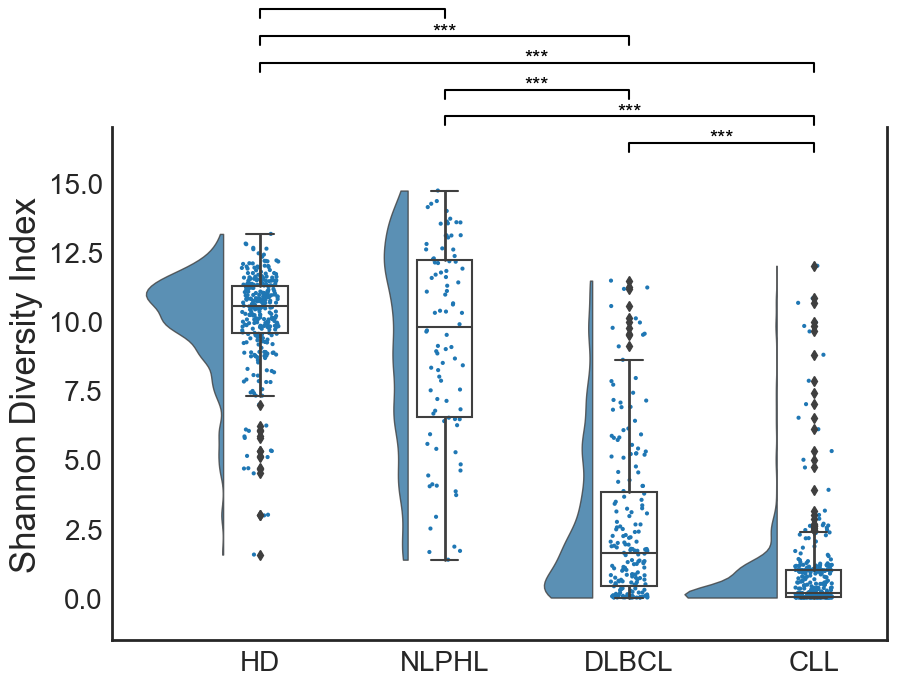

In [144]:
fig, ax = plt.subplots(figsize=(10,6.66))
#sns.violinplot(data=X, x="Class", y="shannon", ax=ax, width = 0.9, color="C0", scale="count", cut=0)
#sns.swarmplot(x ='Class', y ='shannon', data=X, color= "black", alpha=0.4)
pt.RainCloud(x = "Class", y = "shannon", data = X,scale = "count", cut =0,
                     width_viol = 1, width_box=0.3, offset=0.2,ax = ax, pointplot = False, 
             alpha = .8, dodge = True, palette=["C0"])


significant_combinations = []
classes = X.Class.unique()
class_index_dict  = {}
for i,c in enumerate(classes):
    class_index_dict[c] = i
combinations = itertools.combinations(classes,2)
for i, j in list(combinations):
    print(i,j)
    data1 = X[X.Class == i].shannon
    data2 = X[X.Class == j].shannon
    
    # Significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    #if p < 0.05:
    significant_combinations.append([(i,j), p])

#ax.set_ylim((0,1))        
bottom, top = ax.get_ylim()
y_range = top - bottom
# Significance bars
for i, significant_combination in enumerate(significant_combinations):   
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (y_range * 0.06 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1.5, c='k',clip_on=False
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = ''
    text_height = bar_height*0.99
    plt.text((class_index_dict[x1] + class_index_dict[x2]) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize=15)

ax.set_ylim(0-top*0.1,top + top*0.1)
ax.spines[['top']].set_visible(False)
ax.spines[['right', 'bottom','left']].set_linewidth(2)
ax.tick_params(axis='both', labelsize=20)
ax.set_ylabel("Shannon Diversity Index",fontsize=25)
ax.set_xticks([-0.8, 0, 1, 2, 3, 3.4])
ax.set_xlabel("", fontsize=18)

if SAVE_PLOTS:
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig('diversity.svg', format="svg", bbox_inches='tight')

In [85]:
X.groupby("Class")["shannon"].median()

Class
CLL       0.159571
DLBCL     1.604834
HD       10.545649
NLPHL     9.788316
Name: shannon, dtype: float64

In [87]:
SAVE_PLOTS = False

HD NLPHL
HD DLBCL
HD CLL
NLPHL DLBCL
NLPHL CLL
DLBCL CLL
0.702701968832874
1.565967457384775e-53
4.547116318841586e-92
4.981233224359423e-22
3.983990832438042e-35
2.955499299273151e-09


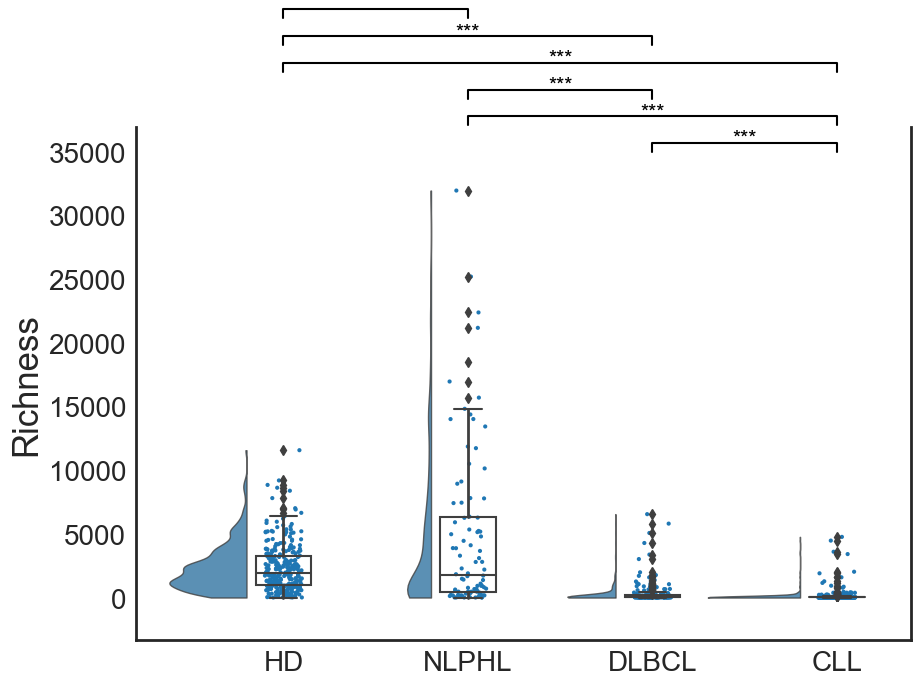

In [145]:
fig, ax = plt.subplots(figsize=(10,6.66))
#sns.violinplot(data=X, x="Class", y="richness", ax=ax, width = 0.9, color="C0", scale="count", cut=0)
pt.RainCloud(x = "Class", y = "richness", data = X,scale = "count", cut=0,
                     width_viol = 1, width_box=0.3, offset=0.2,ax = ax, pointplot = False, 
             alpha = .8, dodge = True, palette=["C0"])
significant_combinations = []
classes = X.Class.unique()
class_index_dict  = {}
for i,c in enumerate(classes):
    class_index_dict[c] = i
combinations = itertools.combinations(classes,2)
for i, j in list(combinations):
    print(i,j)
    data1 = X[X.Class == i].richness
    data2 = X[X.Class == j].richness
    
    # Significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    #if p < 0.05:
    significant_combinations.append([(i,j), p])

#ax.set_ylim((0,1))        
bottom, top = ax.get_ylim()
y_range = top - bottom
# Significance bars
for i, significant_combination in enumerate(significant_combinations):   
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (y_range * 0.06 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1.5, c='k',clip_on=False
    )
    # Significance level
    p = significant_combination[1]
    print(p)
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = ''
    text_height = bar_height*0.99
    plt.text((class_index_dict[x1] + class_index_dict[x2]) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize=15)

ax.set_ylim(0-top*0.1,top + top*0.1)
ax.spines[['top']].set_visible(False)
ax.spines[['right', 'bottom','left']].set_linewidth(2)
ax.tick_params(axis='both', labelsize=20)
ax.set_ylabel("Richness",fontsize=25)
ax.set_xlabel("", fontsize=18)
ax.set_xticks([-0.8, 0, 1, 2, 3, 3.4])
if SAVE_PLOTS:
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig('richness.svg', format="svg", bbox_inches='tight')

In [89]:
X.groupby("Class")["richness"].median()

Class
CLL        14.0
DLBCL      38.0
HD       1959.0
NLPHL    1777.0
Name: richness, dtype: float64

In [91]:
class_files, number_of_repertoires = run_classical.load_metadata(comparisons, "IGH", path_dir)

Number of Class 1 repertoires: 90
Number of Class 2 repertoires: 182
Number of Class 3 repertoires: 291
Number of Class 4 repertoires: 348


In [92]:
target_lanels = ["NLPHL", "DLBCL", "HD", "CLL"]

In [93]:
df = pd.DataFrame()
for i in range(4):
    files = class_files[i]
    label = target_lanels[i]
    df_ = utils.read_clones_txt(files, clones_txt_dict= "data/clones_mit_kidera", normalize_read_count = None)
    df_["class"] = label
    df = pd.concat([df, df_])

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

In [94]:
df_hyper = []
df_lymph = []
files = []
for i, group in df.groupby("clones.txt.name"):
    #group = group[group['vBestIdentityPercent'].notna()]
    hyper_group = group[group.vBestIdentityPercent < 0.98]
    per = np.sum(hyper_group.cloneFraction)
    df_hyper.append(per)
    df_lymph.append(group["class"].iloc[0])
    files.append(i)

In [95]:
df_hyp = pd.DataFrame({"hyper": df_hyper, "class": df_lymph, "file":files})

In [96]:
df_hyp

hyper class                                               file
0    0.086102    HD       101-D0-Ig-gDNA-PB-Nuray-A250_S240.clones.txt
1    0.193221    HD      101-D28-Ig-gDNA-PB-Nuray-A250_S190.clones.txt
2    0.197785    HD       105-D0-Ig-gDNA-PB-Nuray-A250_S179.clones.txt
3    0.151463    HD         105-D14-Ig-gDNA-human-Nuray_S59.clones.txt
4    0.198312    HD          105-D7-Ig-gDNA-human-Nuray_S58.clones.txt
..        ...   ...                                                ...
906  0.000031   CLL                   Simon-Ig-CLL-I3P_S200.clones.txt
907  0.218488    HD        Svenja-IGH-HD121-28-10-2020_S161.clones.txt
908  0.538559    HD                   Svenja-IGH-HD128_S162.clones.txt
909  0.301457    HD                   Svenja-IGH-HD129_S163.clones.txt
910  0.000438   CLL  TWOIST-20-08-2015-Ig-DNA-Chris-m-binder-A250-M...

[911 rows x 3 columns]

In [97]:
df_hyp["hyper"] = df_hyp["hyper"]  * 100

In [98]:
custom_order = ['HD', 'NLPHL', 'DLBCL', 'CLL']
sorting_key = df_hyp['class'].map(lambda x: custom_order.index(x))
df_hyp = df_hyp.iloc[sorting_key.argsort()]

In [112]:
SAVE_PLOTS = True

HD NLPHL
HD DLBCL
HD CLL
NLPHL DLBCL
NLPHL CLL
DLBCL CLL


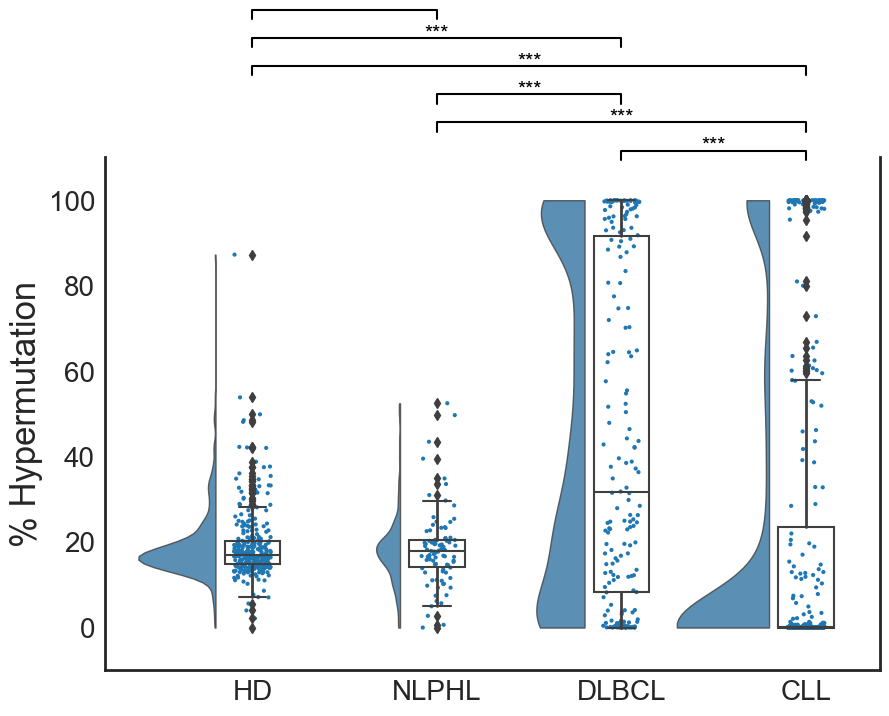

In [146]:
fig, ax = plt.subplots(figsize=(10,6.66))
#sns.violinplot(data=X, x="Class", y="richness", ax=ax, width = 0.9, color="C0", scale="count", cut=0)
pt.RainCloud(x = "class", y = "hyper", data = df_hyp,scale = "count", cut=0,
                     width_viol = 1, width_box=0.3, offset=0.2,ax = ax, pointplot = False, 
             alpha = .8, dodge = True, palette=["C0"])
significant_combinations = []
classes = df_hyp["class"].unique()
class_index_dict  = {}
for i,c in enumerate(classes):
    class_index_dict[c] = i
combinations = itertools.combinations(classes,2)

for i, j in list(combinations):
    print(i,j)
    data1 = df_hyp[df_hyp["class"] == i].hyper
    data2 = df_hyp[df_hyp["class"] == j].hyper
    
    # Significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    #if p < 0.05:
    significant_combinations.append([(i,j), p])
      
bottom, top = ax.get_ylim()
y_range = top - bottom
# Significance bars
for i, significant_combination in enumerate(significant_combinations):   
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (y_range * 0.06 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1.5, c='k',clip_on=False
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = ''
    text_height = bar_height*0.99
    plt.text((class_index_dict[x1] + class_index_dict[x2]) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize=15)

yticks = []
for tick in ax.get_yticklabels():
    tick_text = tick.get_text()
    tick_number = float(tick.get_text().replace('−', '-'))
    if tick_number >100:
        yticks.append("")
    else:
        yticks.append(tick_text)
ax.set_xticks([-0.8, 0, 1, 2, 3, 3.4])
ax.set_yticklabels(list(yticks))
    
ax.set_ylim(0-100*0.1,100 + 100 * 0.1)
ax.spines[['top']].set_visible(False)
ax.spines[['right', 'bottom','left']].set_linewidth(2)
ax.tick_params(axis='both', labelsize=20)
ax.set_ylabel("% Hypermutation",fontsize=25)
ax.set_xlabel("", fontsize=18)
#ax.set_yscale('log')

if SAVE_PLOTS:
    #plt.savefig('hypermutation.svg', format="svg", bbox_inches='tight')
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig("hypermutation.svg", format="svg", bbox_inches="tight")

In [105]:
df_hyp.groupby("class")["hyper"].mean()

class
CLL      22.399916
DLBCL    44.940229
HD       19.163658
NLPHL    18.426279
Name: hyper, dtype: float64

In [106]:
df_hyp.groupby("class")["hyper"].median()

class
CLL       0.103410
DLBCL    31.677393
HD       16.926801
NLPHL    17.861155
Name: hyper, dtype: float64